In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import concurrent

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import torch
from torch import nn, optim
from torch import autograd
import torch.nn.functional as F
from torch.nn import Parameter
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image, ImageOps, ImageEnhance

import cv2
#import albumentations as A
#from albumentations.pytorch import ToTensor

import glob
import xml.etree.ElementTree as ET #for parsing XML
import shutil
from tqdm import tqdm
import time
import random
from sklearn.feature_extraction.image import extract_patches_2d
from skimage.feature import greycomatrix, greycoprops
#import skopt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print("The current working directory is:", os.getcwd())
# Any results you write to the current directory are saved as output.

from big_vqvae_2 import VQVAE
from train_big_vqvae import train_vqvae_model
#from train_vae_gan import train_gan_model
from lung_dataset import LungDataset, create_data_loader
#from discriminator import Discriminator

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ['CUDA_VISIBLE_DEVICES']='4,5,6,7'#,8,9'#,1,2,3'

The current working directory is: C:\Users\W.Rogers\PixelCNN\ii


In [2]:
img_size    = 64
batch_size  = 141
n_epochs    = 4096

In [3]:
train_loader = create_data_loader(batch_size, split=False, train=True)
print("The length of the training set is", len(train_loader))

loading images: 100%|███████████████████████████████████████████████████████████████| 423/423 [00:03<00:00, 130.11it/s]


... LUNG1 Dataset Intialized with 423 scans
The length of the training set is 3


Data shape: (141, 3, 128, 128)
 Min and max values: 0.0 1.0


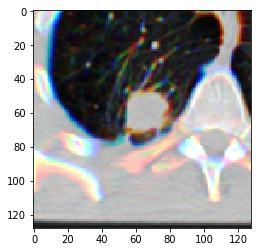

In [4]:
#label_names = ['cracked', 'banded', 'striped']
for ii, data in enumerate(train_loader):
    if ii > 0: break
    imgs = np.array([np.array(img) for img in data])
    print("Data shape: {}".format(imgs.shape))
    print(" Min and max values:", imgs.min(), imgs.max())
    img = imgs[0]
    img = np.rollaxis(img, -1)
    img = np.rollaxis(img, -1)
    plt.imshow(img.squeeze())

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [6]:
params =   {'lr':.0006,
            'spectral_first_layer':True,
            'spectral_resblock':False,
            'spectral_last_layer':True,
            'attention_1':True,
            'attention_1_size':128,
            'attention_2':True,
            'attention_2_size':128}

In [7]:
'''
SPACE = [skopt.space.Real(0.0008, 0.008, name='lr', prior='log-uniform'),
         skopt.space.Categorical(categories=[True, False], name = 'spectral_first_layer'),
         skopt.space.Categorical(categories=[True, False], name = 'spectral_resblock'),
         skopt.space.Categorical(categories=[True, False], name = 'spectral_last_layer'),
         skopt.space.Categorical(categories=[True, False], name = 'attention_1'),
         skopt.space.Categorical(categories=[True, False], name = 'attention_2'),
         skopt.space.Integer(32, 256, name='attention_1_size'),
         skopt.space.Integer(32, 256, name='attention_2_size'),
         ]
'''

"\nSPACE = [skopt.space.Real(0.0008, 0.008, name='lr', prior='log-uniform'),\n         skopt.space.Categorical(categories=[True, False], name = 'spectral_first_layer'),\n         skopt.space.Categorical(categories=[True, False], name = 'spectral_resblock'),\n         skopt.space.Categorical(categories=[True, False], name = 'spectral_last_layer'),\n         skopt.space.Categorical(categories=[True, False], name = 'attention_1'),\n         skopt.space.Categorical(categories=[True, False], name = 'attention_2'),\n         skopt.space.Integer(32, 256, name='attention_1_size'),\n         skopt.space.Integer(32, 256, name='attention_2_size'),\n         ]\n"

In [8]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight.data)
        #torch.nn.init.kaiming_uniform_(m.bias.data)
        
model = nn.DataParallel(VQVAE(params)).to(device)
model = model.apply(weights_init)

In [9]:
optimizer = optim.Adam(model.parameters(), lr=params['lr'])

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\cuda\nccl.py:24: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')
epoch: 1; mse: 0.09376; latent: 1.794; avg mse: 0.14606; lr: 0.00060: 100%|██████████████| 3/3 [00:13<00:00,  4.38s/it]
epoch: 2; mse: 0.05167; latent: 0.643; avg mse: 0.05600; lr: 0.00060: 100%|██████████████| 3/3 [00:01<00:00,  2.70it/s]
epoch: 3; mse: 0.03649; latent: 0.383; avg mse: 0.04045; lr: 0.00060: 100%|██████████████| 3/3 [00:01<00:00,  2.65it/s]
epoch: 4; mse: 0.03366; latent: 0.276; avg mse: 0.03429; lr: 0.00060: 100%|██████████████| 3/3 [00:01<00:00,  2.70it/s]
epoch: 5; mse: 0.02886; latent: 0.215; avg mse: 0.03030; lr: 0.00060: 100%|██████████████| 3/3 [00:01<00:00,  2.55it/s]
epoch: 6; mse: 0.02774; latent: 0.172; avg mse: 0.02810; lr: 0.00060: 100%|██████████████| 3/3 [00:

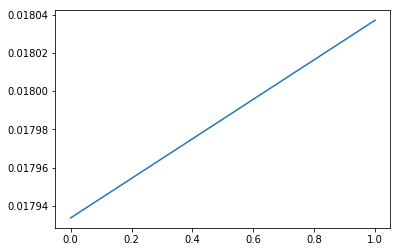

epoch: 34; mse: 0.01150; latent: 0.027; avg mse: 0.01101; lr: 0.00060: 100%|█████████████| 3/3 [00:01<00:00,  2.66it/s]
epoch: 35; mse: 0.01116; latent: 0.026; avg mse: 0.01109; lr: 0.00060: 100%|█████████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 36; mse: 0.01061; latent: 0.024; avg mse: 0.01136; lr: 0.00060: 100%|█████████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 37; mse: 0.01045; latent: 0.024; avg mse: 0.01091; lr: 0.00060: 100%|█████████████| 3/3 [00:01<00:00,  2.41it/s]
epoch: 38; mse: 0.01095; latent: 0.024; avg mse: 0.01071; lr: 0.00060: 100%|█████████████| 3/3 [00:01<00:00,  2.45it/s]
epoch: 39; mse: 0.01009; latent: 0.023; avg mse: 0.01019; lr: 0.00060: 100%|█████████████| 3/3 [00:01<00:00,  2.24it/s]
epoch: 40; mse: 0.01017; latent: 0.022; avg mse: 0.01020; lr: 0.00060: 100%|█████████████| 3/3 [00:01<00:00,  2.87it/s]
epoch: 41; mse: 0.01010; latent: 0.022; avg mse: 0.00999; lr: 0.00060: 100%|█████████████| 3/3 [00:00<00:00,  3.07it/s]
epoch: 42; mse: 0.00989; latent: 0.022; 

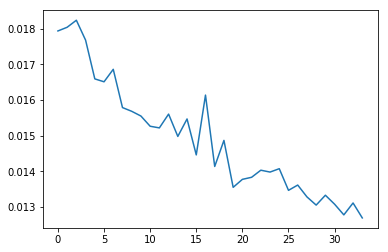

epoch: 66; mse: 0.00920; latent: 0.017; avg mse: 0.00879; lr: 0.00060: 100%|█████████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 67; mse: 0.00850; latent: 0.016; avg mse: 0.00860; lr: 0.00060: 100%|█████████████| 3/3 [00:00<00:00,  3.46it/s]
epoch: 68; mse: 0.00850; latent: 0.016; avg mse: 0.00865; lr: 0.00060: 100%|█████████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 69; mse: 0.00891; latent: 0.017; avg mse: 0.00867; lr: 0.00060: 100%|█████████████| 3/3 [00:00<00:00,  3.44it/s]
epoch: 70; mse: 0.00879; latent: 0.017; avg mse: 0.00868; lr: 0.00060: 100%|█████████████| 3/3 [00:01<00:00,  2.65it/s]
epoch: 71; mse: 0.00909; latent: 0.019; avg mse: 0.00893; lr: 0.00060: 100%|█████████████| 3/3 [00:00<00:00,  3.22it/s]
epoch: 72; mse: 0.00833; latent: 0.018; avg mse: 0.00861; lr: 0.00060: 100%|█████████████| 3/3 [00:01<00:00,  2.57it/s]
epoch: 73; mse: 0.00930; latent: 0.016; avg mse: 0.00915; lr: 0.00060: 100%|█████████████| 3/3 [00:00<00:00,  3.01it/s]
epoch: 74; mse: 0.00902; latent: 0.017; 

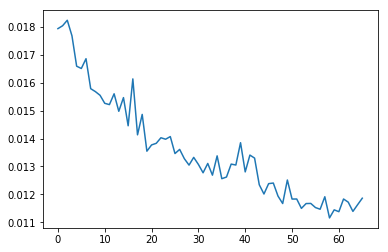

epoch: 98; mse: 0.00785; latent: 0.015; avg mse: 0.00772; lr: 0.00060: 100%|█████████████| 3/3 [00:01<00:00,  2.26it/s]
epoch: 99; mse: 0.00790; latent: 0.015; avg mse: 0.00784; lr: 0.00060: 100%|█████████████| 3/3 [00:00<00:00,  3.62it/s]
epoch: 100; mse: 0.00768; latent: 0.014; avg mse: 0.00765; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  1.92it/s]
epoch: 101; mse: 0.00772; latent: 0.015; avg mse: 0.00757; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 102; mse: 0.00726; latent: 0.014; avg mse: 0.00745; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.75it/s]
epoch: 103; mse: 0.00764; latent: 0.014; avg mse: 0.00753; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.83it/s]
epoch: 104; mse: 0.00753; latent: 0.014; avg mse: 0.00756; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.93it/s]
epoch: 105; mse: 0.00745; latent: 0.015; avg mse: 0.00760; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.76it/s]
epoch: 106; mse: 0.00766; latent: 0.015;

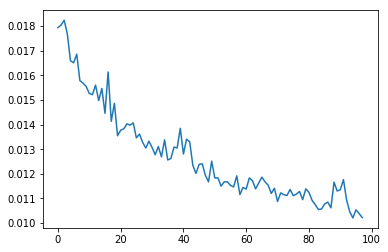

epoch: 130; mse: 0.00709; latent: 0.014; avg mse: 0.00697; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  3.00it/s]
epoch: 131; mse: 0.00711; latent: 0.014; avg mse: 0.00696; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.99it/s]
epoch: 132; mse: 0.00689; latent: 0.013; avg mse: 0.00699; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.84it/s]
epoch: 133; mse: 0.00672; latent: 0.013; avg mse: 0.00706; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.95it/s]
epoch: 134; mse: 0.00707; latent: 0.013; avg mse: 0.00707; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.20it/s]
epoch: 135; mse: 0.00672; latent: 0.013; avg mse: 0.00686; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.19it/s]
epoch: 136; mse: 0.00725; latent: 0.013; avg mse: 0.00689; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.68it/s]
epoch: 137; mse: 0.00692; latent: 0.014; avg mse: 0.00705; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.96it/s]
epoch: 138; mse: 0.00803; latent: 0.013;

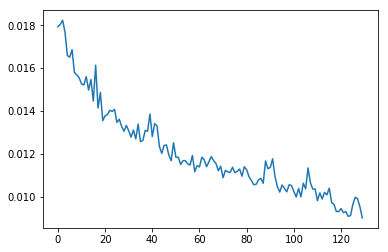

epoch: 162; mse: 0.00639; latent: 0.011; avg mse: 0.00655; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.46it/s]
epoch: 163; mse: 0.00656; latent: 0.010; avg mse: 0.00629; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.52it/s]
epoch: 164; mse: 0.00626; latent: 0.011; avg mse: 0.00625; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.30it/s]
epoch: 165; mse: 0.00641; latent: 0.011; avg mse: 0.00626; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.55it/s]
epoch: 166; mse: 0.00629; latent: 0.010; avg mse: 0.00621; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.30it/s]
epoch: 167; mse: 0.00619; latent: 0.011; avg mse: 0.00623; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.59it/s]
epoch: 168; mse: 0.00646; latent: 0.011; avg mse: 0.00632; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.37it/s]
epoch: 169; mse: 0.00600; latent: 0.010; avg mse: 0.00616; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.50it/s]
epoch: 170; mse: 0.00596; latent: 0.011;

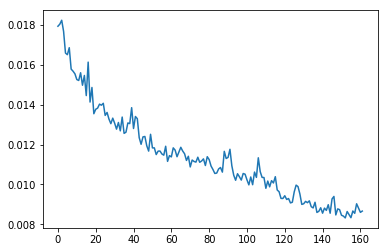

epoch: 194; mse: 0.00659; latent: 0.010; avg mse: 0.00633; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.58it/s]
epoch: 195; mse: 0.00619; latent: 0.010; avg mse: 0.00612; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.40it/s]
epoch: 196; mse: 0.00602; latent: 0.010; avg mse: 0.00609; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.68it/s]
epoch: 197; mse: 0.00615; latent: 0.010; avg mse: 0.00616; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.54it/s]
epoch: 198; mse: 0.00618; latent: 0.011; avg mse: 0.00613; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.42it/s]
epoch: 199; mse: 0.00599; latent: 0.010; avg mse: 0.00607; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.55it/s]
epoch: 200; mse: 0.00617; latent: 0.010; avg mse: 0.00602; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.85it/s]
epoch: 201; mse: 0.00591; latent: 0.010; avg mse: 0.00592; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 202; mse: 0.00568; latent: 0.010;

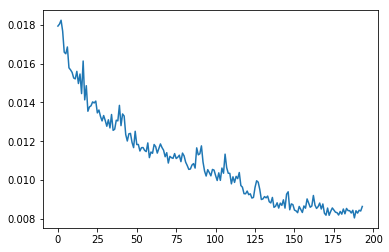

epoch: 226; mse: 0.00640; latent: 0.010; avg mse: 0.00671; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.36it/s]
epoch: 227; mse: 0.00624; latent: 0.010; avg mse: 0.00606; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 228; mse: 0.00592; latent: 0.010; avg mse: 0.00640; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.92it/s]
epoch: 229; mse: 0.00624; latent: 0.010; avg mse: 0.00621; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 230; mse: 0.00623; latent: 0.010; avg mse: 0.00603; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.48it/s]
epoch: 231; mse: 0.00575; latent: 0.009; avg mse: 0.00616; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.33it/s]
epoch: 232; mse: 0.00604; latent: 0.010; avg mse: 0.00643; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.45it/s]
epoch: 233; mse: 0.00594; latent: 0.010; avg mse: 0.00615; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.07it/s]
epoch: 234; mse: 0.00596; latent: 0.009;

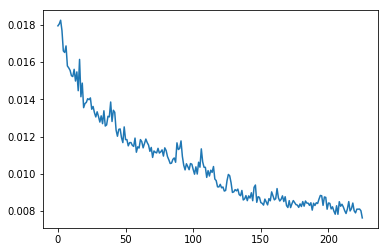

epoch: 258; mse: 0.00572; latent: 0.009; avg mse: 0.00587; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.26it/s]
epoch: 259; mse: 0.00598; latent: 0.010; avg mse: 0.00584; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.71it/s]
epoch: 260; mse: 0.00570; latent: 0.010; avg mse: 0.00574; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.28it/s]
epoch: 261; mse: 0.00561; latent: 0.009; avg mse: 0.00574; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.62it/s]
epoch: 262; mse: 0.00588; latent: 0.009; avg mse: 0.00570; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.89it/s]
epoch: 263; mse: 0.00576; latent: 0.009; avg mse: 0.00584; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.06it/s]
epoch: 264; mse: 0.00578; latent: 0.009; avg mse: 0.00572; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.45it/s]
epoch: 265; mse: 0.00589; latent: 0.009; avg mse: 0.00594; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.40it/s]
epoch: 266; mse: 0.00582; latent: 0.009;

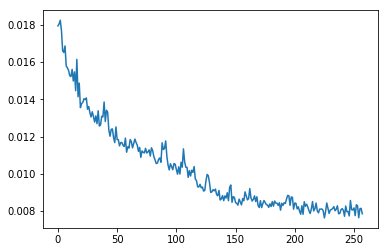

epoch: 290; mse: 0.00545; latent: 0.009; avg mse: 0.00560; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.85it/s]
epoch: 291; mse: 0.00560; latent: 0.008; avg mse: 0.00574; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.58it/s]
epoch: 292; mse: 0.00581; latent: 0.009; avg mse: 0.00567; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.60it/s]
epoch: 293; mse: 0.00542; latent: 0.009; avg mse: 0.00565; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 294; mse: 0.00574; latent: 0.009; avg mse: 0.00569; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.68it/s]
epoch: 295; mse: 0.00551; latent: 0.009; avg mse: 0.00566; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.77it/s]
epoch: 296; mse: 0.00554; latent: 0.008; avg mse: 0.00564; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.88it/s]
epoch: 297; mse: 0.00576; latent: 0.009; avg mse: 0.00564; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.56it/s]
epoch: 298; mse: 0.00541; latent: 0.009;

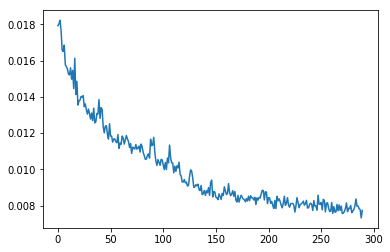

epoch: 322; mse: 0.00581; latent: 0.009; avg mse: 0.00565; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.66it/s]
epoch: 323; mse: 0.00579; latent: 0.009; avg mse: 0.00570; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.39it/s]
epoch: 324; mse: 0.00569; latent: 0.008; avg mse: 0.00564; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.50it/s]
epoch: 325; mse: 0.00556; latent: 0.009; avg mse: 0.00558; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.41it/s]
epoch: 326; mse: 0.00570; latent: 0.009; avg mse: 0.00567; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.70it/s]
epoch: 327; mse: 0.00558; latent: 0.009; avg mse: 0.00558; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.93it/s]
epoch: 328; mse: 0.00556; latent: 0.008; avg mse: 0.00553; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.83it/s]
epoch: 329; mse: 0.00537; latent: 0.009; avg mse: 0.00550; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.95it/s]
epoch: 330; mse: 0.00577; latent: 0.009;

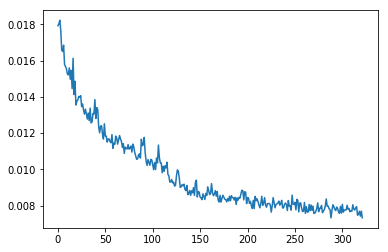

epoch: 354; mse: 0.00539; latent: 0.009; avg mse: 0.00545; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.86it/s]
epoch: 355; mse: 0.00546; latent: 0.009; avg mse: 0.00566; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 356; mse: 0.00545; latent: 0.008; avg mse: 0.00556; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.39it/s]
epoch: 357; mse: 0.00544; latent: 0.008; avg mse: 0.00547; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.62it/s]
epoch: 358; mse: 0.00548; latent: 0.008; avg mse: 0.00554; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 359; mse: 0.00561; latent: 0.009; avg mse: 0.00552; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 360; mse: 0.00568; latent: 0.008; avg mse: 0.00550; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.32it/s]
epoch: 361; mse: 0.00563; latent: 0.008; avg mse: 0.00557; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.63it/s]
epoch: 362; mse: 0.00554; latent: 0.008;

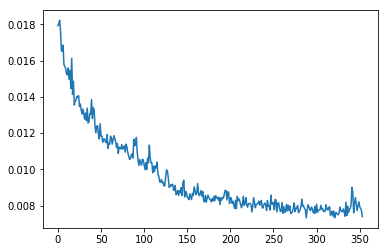

epoch: 386; mse: 0.00534; latent: 0.009; avg mse: 0.00540; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.06it/s]
epoch: 387; mse: 0.00555; latent: 0.008; avg mse: 0.00543; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 388; mse: 0.00539; latent: 0.008; avg mse: 0.00540; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.17it/s]
epoch: 389; mse: 0.00556; latent: 0.008; avg mse: 0.00551; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.66it/s]
epoch: 390; mse: 0.00535; latent: 0.008; avg mse: 0.00546; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.43it/s]
epoch: 391; mse: 0.00558; latent: 0.008; avg mse: 0.00567; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.53it/s]
epoch: 392; mse: 0.00550; latent: 0.009; avg mse: 0.00548; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.52it/s]
epoch: 393; mse: 0.00525; latent: 0.009; avg mse: 0.00541; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.20it/s]
epoch: 394; mse: 0.00560; latent: 0.008;

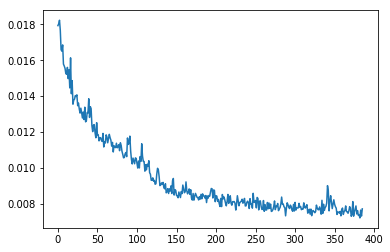

epoch: 418; mse: 0.00550; latent: 0.009; avg mse: 0.00568; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.67it/s]
epoch: 419; mse: 0.00541; latent: 0.008; avg mse: 0.00546; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.97it/s]
epoch: 420; mse: 0.00546; latent: 0.008; avg mse: 0.00541; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.81it/s]
epoch: 421; mse: 0.00529; latent: 0.008; avg mse: 0.00532; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.98it/s]
epoch: 422; mse: 0.00535; latent: 0.009; avg mse: 0.00531; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 423; mse: 0.00566; latent: 0.008; avg mse: 0.00555; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.02it/s]
epoch: 424; mse: 0.00547; latent: 0.008; avg mse: 0.00554; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.58it/s]
epoch: 425; mse: 0.00543; latent: 0.008; avg mse: 0.00539; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.06it/s]
epoch: 426; mse: 0.00528; latent: 0.008;

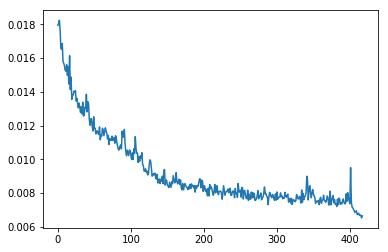

epoch: 450; mse: 0.00501; latent: 0.006; avg mse: 0.00507; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.46it/s]
epoch: 451; mse: 0.00490; latent: 0.006; avg mse: 0.00511; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.48it/s]
epoch: 452; mse: 0.00532; latent: 0.006; avg mse: 0.00513; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.36it/s]
epoch: 453; mse: 0.00518; latent: 0.006; avg mse: 0.00533; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.42it/s]
epoch: 454; mse: 0.00548; latent: 0.006; avg mse: 0.00546; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.52it/s]
epoch: 455; mse: 0.00542; latent: 0.006; avg mse: 0.00527; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  1.91it/s]
epoch: 456; mse: 0.00511; latent: 0.006; avg mse: 0.00541; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.67it/s]
epoch: 457; mse: 0.00533; latent: 0.006; avg mse: 0.00520; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.92it/s]
epoch: 458; mse: 0.00533; latent: 0.006;

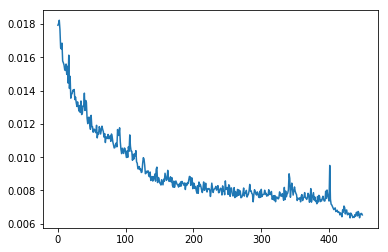

epoch: 482; mse: 0.00511; latent: 0.006; avg mse: 0.00503; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.86it/s]
epoch: 483; mse: 0.00512; latent: 0.006; avg mse: 0.00506; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.80it/s]
epoch: 484; mse: 0.00497; latent: 0.006; avg mse: 0.00505; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.92it/s]
epoch: 485; mse: 0.00520; latent: 0.006; avg mse: 0.00506; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.68it/s]
epoch: 486; mse: 0.00510; latent: 0.006; avg mse: 0.00506; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.23it/s]
epoch: 487; mse: 0.00524; latent: 0.006; avg mse: 0.00529; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.51it/s]
epoch: 488; mse: 0.00496; latent: 0.006; avg mse: 0.00521; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.94it/s]
epoch: 489; mse: 0.00489; latent: 0.006; avg mse: 0.00493; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.80it/s]
epoch: 490; mse: 0.00502; latent: 0.006;

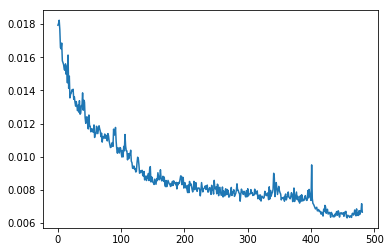

epoch: 514; mse: 0.00527; latent: 0.006; avg mse: 0.00553; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.73it/s]
epoch: 515; mse: 0.00553; latent: 0.006; avg mse: 0.00524; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 516; mse: 0.00477; latent: 0.006; avg mse: 0.00509; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.73it/s]
epoch: 517; mse: 0.00502; latent: 0.006; avg mse: 0.00522; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.87it/s]
epoch: 518; mse: 0.00511; latent: 0.006; avg mse: 0.00503; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.04it/s]
epoch: 519; mse: 0.00476; latent: 0.006; avg mse: 0.00499; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.47it/s]
epoch: 520; mse: 0.00480; latent: 0.006; avg mse: 0.00507; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.31it/s]
epoch: 521; mse: 0.00504; latent: 0.006; avg mse: 0.00502; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.56it/s]
epoch: 522; mse: 0.00519; latent: 0.006;

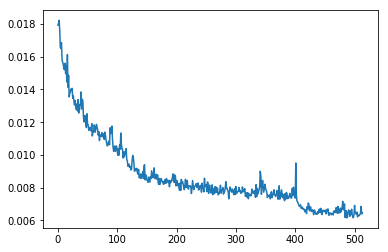

epoch: 546; mse: 0.00502; latent: 0.006; avg mse: 0.00505; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.48it/s]
epoch: 547; mse: 0.00476; latent: 0.006; avg mse: 0.00489; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.29it/s]
epoch: 548; mse: 0.00491; latent: 0.006; avg mse: 0.00491; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.11it/s]
epoch: 549; mse: 0.00488; latent: 0.006; avg mse: 0.00500; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.75it/s]
epoch: 550; mse: 0.00508; latent: 0.006; avg mse: 0.00512; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.91it/s]
epoch: 551; mse: 0.00498; latent: 0.006; avg mse: 0.00497; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.79it/s]
epoch: 552; mse: 0.00493; latent: 0.006; avg mse: 0.00489; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.65it/s]
epoch: 553; mse: 0.00479; latent: 0.006; avg mse: 0.00500; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.23it/s]
epoch: 554; mse: 0.00555; latent: 0.006;

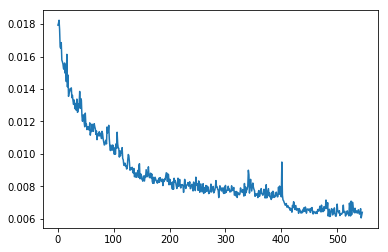

epoch: 578; mse: 0.00502; latent: 0.005; avg mse: 0.00494; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.53it/s]
epoch: 579; mse: 0.00480; latent: 0.005; avg mse: 0.00493; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.85it/s]
epoch: 580; mse: 0.00494; latent: 0.005; avg mse: 0.00503; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.52it/s]
epoch: 581; mse: 0.00498; latent: 0.006; avg mse: 0.00493; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.58it/s]
epoch: 582; mse: 0.00474; latent: 0.005; avg mse: 0.00488; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.56it/s]
epoch: 583; mse: 0.00495; latent: 0.006; avg mse: 0.00498; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.86it/s]
epoch: 584; mse: 0.00528; latent: 0.006; avg mse: 0.00501; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.59it/s]
epoch: 585; mse: 0.00501; latent: 0.005; avg mse: 0.00507; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.54it/s]
epoch: 586; mse: 0.00481; latent: 0.005;

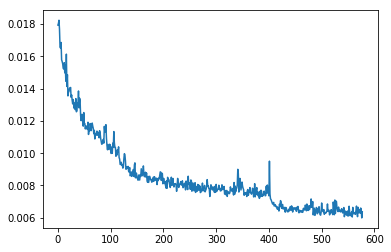

epoch: 610; mse: 0.00518; latent: 0.006; avg mse: 0.00511; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.79it/s]
epoch: 611; mse: 0.00489; latent: 0.005; avg mse: 0.00495; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.87it/s]
epoch: 612; mse: 0.00476; latent: 0.005; avg mse: 0.00492; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 613; mse: 0.00481; latent: 0.005; avg mse: 0.00497; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.88it/s]
epoch: 614; mse: 0.00533; latent: 0.005; avg mse: 0.00500; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.50it/s]
epoch: 615; mse: 0.00481; latent: 0.005; avg mse: 0.00484; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.33it/s]
epoch: 616; mse: 0.00480; latent: 0.005; avg mse: 0.00490; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.22it/s]
epoch: 617; mse: 0.00491; latent: 0.006; avg mse: 0.00492; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.44it/s]
epoch: 618; mse: 0.00487; latent: 0.005;

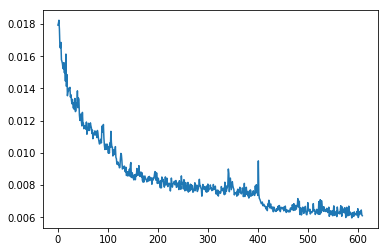

epoch: 642; mse: 0.00477; latent: 0.005; avg mse: 0.00483; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.73it/s]
epoch: 643; mse: 0.00482; latent: 0.005; avg mse: 0.00484; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 644; mse: 0.00497; latent: 0.005; avg mse: 0.00487; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.66it/s]
epoch: 645; mse: 0.00517; latent: 0.005; avg mse: 0.00505; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.15it/s]
epoch: 646; mse: 0.00482; latent: 0.006; avg mse: 0.00488; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.66it/s]
epoch: 647; mse: 0.00519; latent: 0.005; avg mse: 0.00517; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.14it/s]
epoch: 648; mse: 0.00501; latent: 0.005; avg mse: 0.00490; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.39it/s]
epoch: 649; mse: 0.00497; latent: 0.006; avg mse: 0.00489; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.34it/s]
epoch: 650; mse: 0.00486; latent: 0.005;

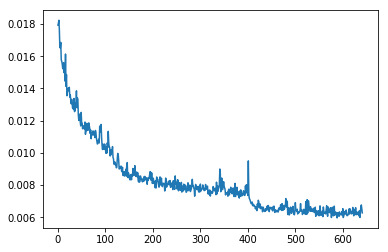

epoch: 674; mse: 0.00476; latent: 0.006; avg mse: 0.00491; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.67it/s]
epoch: 675; mse: 0.00495; latent: 0.006; avg mse: 0.00492; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.97it/s]
epoch: 676; mse: 0.00487; latent: 0.005; avg mse: 0.00489; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.06it/s]
epoch: 677; mse: 0.00479; latent: 0.005; avg mse: 0.00503; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 678; mse: 0.00483; latent: 0.005; avg mse: 0.00476; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.65it/s]
epoch: 679; mse: 0.00486; latent: 0.005; avg mse: 0.00483; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.81it/s]
epoch: 680; mse: 0.00480; latent: 0.005; avg mse: 0.00488; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.04it/s]
epoch: 681; mse: 0.00472; latent: 0.005; avg mse: 0.00479; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.79it/s]
epoch: 682; mse: 0.00498; latent: 0.005;

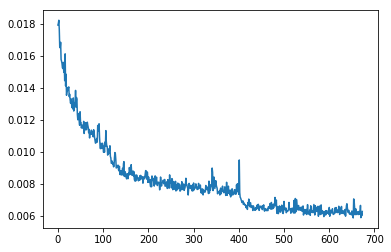

epoch: 706; mse: 0.00476; latent: 0.006; avg mse: 0.00472; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.26it/s]
epoch: 707; mse: 0.00475; latent: 0.005; avg mse: 0.00483; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.58it/s]
epoch: 708; mse: 0.00474; latent: 0.005; avg mse: 0.00477; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.52it/s]
epoch: 709; mse: 0.00491; latent: 0.005; avg mse: 0.00495; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.45it/s]
epoch: 710; mse: 0.00469; latent: 0.005; avg mse: 0.00487; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.41it/s]
epoch: 711; mse: 0.00475; latent: 0.005; avg mse: 0.00479; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 712; mse: 0.00467; latent: 0.005; avg mse: 0.00472; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.07it/s]
epoch: 713; mse: 0.00506; latent: 0.005; avg mse: 0.00483; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.96it/s]
epoch: 714; mse: 0.00520; latent: 0.005;

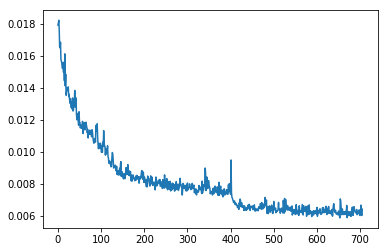

epoch: 738; mse: 0.00495; latent: 0.005; avg mse: 0.00490; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.54it/s]
epoch: 739; mse: 0.00495; latent: 0.006; avg mse: 0.00509; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.45it/s]
epoch: 740; mse: 0.00505; latent: 0.005; avg mse: 0.00487; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.70it/s]
epoch: 741; mse: 0.00508; latent: 0.005; avg mse: 0.00499; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.44it/s]
epoch: 742; mse: 0.00497; latent: 0.005; avg mse: 0.00499; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.62it/s]
epoch: 743; mse: 0.00478; latent: 0.005; avg mse: 0.00482; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.47it/s]
epoch: 744; mse: 0.00484; latent: 0.005; avg mse: 0.00478; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.52it/s]
epoch: 745; mse: 0.00484; latent: 0.005; avg mse: 0.00474; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.23it/s]
epoch: 746; mse: 0.00509; latent: 0.005;

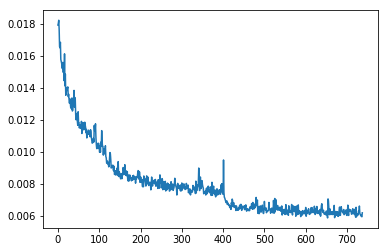

epoch: 770; mse: 0.00567; latent: 0.005; avg mse: 0.00513; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.84it/s]
epoch: 771; mse: 0.00474; latent: 0.005; avg mse: 0.00501; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.01it/s]
epoch: 772; mse: 0.00499; latent: 0.005; avg mse: 0.00517; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.04it/s]
epoch: 773; mse: 0.00482; latent: 0.005; avg mse: 0.00484; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.02it/s]
epoch: 774; mse: 0.00501; latent: 0.005; avg mse: 0.00486; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.79it/s]
epoch: 775; mse: 0.00472; latent: 0.006; avg mse: 0.00488; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.35it/s]
epoch: 776; mse: 0.00465; latent: 0.005; avg mse: 0.00480; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.55it/s]
epoch: 777; mse: 0.00494; latent: 0.005; avg mse: 0.00497; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.16it/s]
epoch: 778; mse: 0.00510; latent: 0.005;

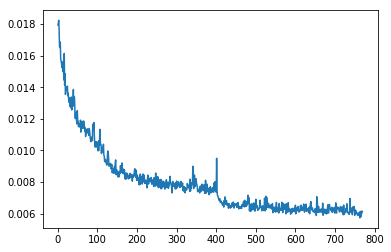

epoch: 802; mse: 0.00456; latent: 0.005; avg mse: 0.00460; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.93it/s]
epoch: 803; mse: 0.00464; latent: 0.005; avg mse: 0.00480; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.91it/s]
epoch: 804; mse: 0.00493; latent: 0.005; avg mse: 0.00475; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.26it/s]
epoch: 805; mse: 0.00456; latent: 0.005; avg mse: 0.00465; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.79it/s]
epoch: 806; mse: 0.00447; latent: 0.005; avg mse: 0.00455; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.00it/s]
epoch: 807; mse: 0.00451; latent: 0.005; avg mse: 0.00453; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.60it/s]
epoch: 808; mse: 0.00473; latent: 0.005; avg mse: 0.00468; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.87it/s]
epoch: 809; mse: 0.00477; latent: 0.005; avg mse: 0.00459; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 810; mse: 0.00480; latent: 0.005;

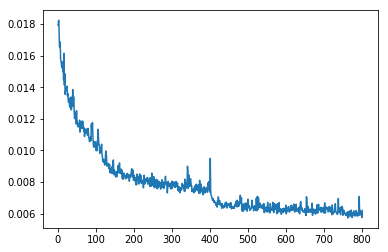

epoch: 834; mse: 0.00469; latent: 0.005; avg mse: 0.00464; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.65it/s]
epoch: 835; mse: 0.00455; latent: 0.005; avg mse: 0.00452; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.87it/s]
epoch: 836; mse: 0.00440; latent: 0.005; avg mse: 0.00444; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.75it/s]
epoch: 837; mse: 0.00461; latent: 0.005; avg mse: 0.00462; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.98it/s]
epoch: 838; mse: 0.00464; latent: 0.005; avg mse: 0.00470; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.69it/s]
epoch: 839; mse: 0.00440; latent: 0.005; avg mse: 0.00449; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.00it/s]
epoch: 840; mse: 0.00436; latent: 0.005; avg mse: 0.00453; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.95it/s]
epoch: 841; mse: 0.00455; latent: 0.005; avg mse: 0.00454; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.40it/s]
epoch: 842; mse: 0.00543; latent: 0.005;

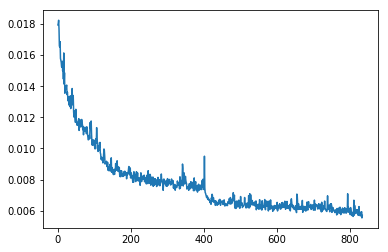

epoch: 866; mse: 0.00462; latent: 0.005; avg mse: 0.00457; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.68it/s]
epoch: 867; mse: 0.00451; latent: 0.005; avg mse: 0.00453; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.41it/s]
epoch: 868; mse: 0.00430; latent: 0.005; avg mse: 0.00450; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.28it/s]
epoch: 869; mse: 0.00429; latent: 0.005; avg mse: 0.00437; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 870; mse: 0.00449; latent: 0.005; avg mse: 0.00451; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.91it/s]
epoch: 871; mse: 0.00458; latent: 0.005; avg mse: 0.00460; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.93it/s]
epoch: 872; mse: 0.00445; latent: 0.005; avg mse: 0.00449; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.77it/s]
epoch: 873; mse: 0.00450; latent: 0.005; avg mse: 0.00442; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.10it/s]
epoch: 874; mse: 0.00456; latent: 0.005;

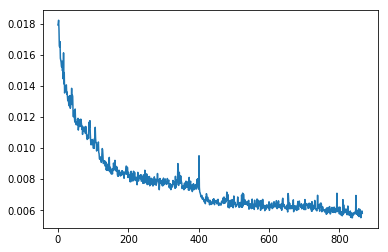

epoch: 898; mse: 0.00451; latent: 0.005; avg mse: 0.00455; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.37it/s]
epoch: 899; mse: 0.00438; latent: 0.005; avg mse: 0.00451; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.55it/s]
epoch: 900; mse: 0.00460; latent: 0.005; avg mse: 0.00452; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.35it/s]
epoch: 901; mse: 0.00434; latent: 0.005; avg mse: 0.00450; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.65it/s]
epoch: 902; mse: 0.00456; latent: 0.005; avg mse: 0.00439; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.01it/s]
epoch: 903; mse: 0.00421; latent: 0.005; avg mse: 0.00458; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.70it/s]
epoch: 904; mse: 0.00417; latent: 0.005; avg mse: 0.00433; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.89it/s]
epoch: 905; mse: 0.00440; latent: 0.005; avg mse: 0.00438; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.82it/s]
epoch: 906; mse: 0.00444; latent: 0.005;

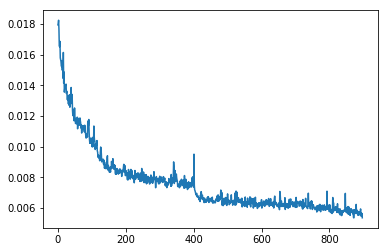

epoch: 930; mse: 0.00450; latent: 0.005; avg mse: 0.00446; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.57it/s]
epoch: 931; mse: 0.00429; latent: 0.005; avg mse: 0.00438; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.10it/s]
epoch: 932; mse: 0.00445; latent: 0.005; avg mse: 0.00453; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.60it/s]
epoch: 933; mse: 0.00450; latent: 0.005; avg mse: 0.00458; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.04it/s]
epoch: 934; mse: 0.00459; latent: 0.005; avg mse: 0.00477; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.03it/s]
epoch: 935; mse: 0.00451; latent: 0.005; avg mse: 0.00436; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.76it/s]
epoch: 936; mse: 0.00458; latent: 0.005; avg mse: 0.00448; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.12it/s]
epoch: 937; mse: 0.00446; latent: 0.005; avg mse: 0.00451; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.83it/s]
epoch: 938; mse: 0.00470; latent: 0.005;

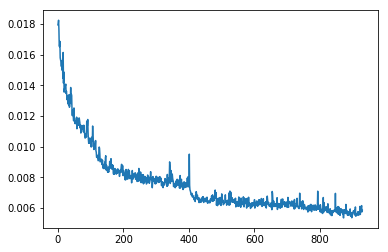

epoch: 962; mse: 0.00456; latent: 0.005; avg mse: 0.00465; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.80it/s]
epoch: 963; mse: 0.00454; latent: 0.005; avg mse: 0.00455; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.76it/s]
epoch: 964; mse: 0.00463; latent: 0.005; avg mse: 0.00442; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.77it/s]
epoch: 965; mse: 0.00449; latent: 0.005; avg mse: 0.00459; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.07it/s]
epoch: 966; mse: 0.00434; latent: 0.005; avg mse: 0.00445; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.89it/s]
epoch: 967; mse: 0.00447; latent: 0.005; avg mse: 0.00433; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.94it/s]
epoch: 968; mse: 0.00449; latent: 0.005; avg mse: 0.00455; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.67it/s]
epoch: 969; mse: 0.00482; latent: 0.005; avg mse: 0.00454; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.20it/s]
epoch: 970; mse: 0.00475; latent: 0.004;

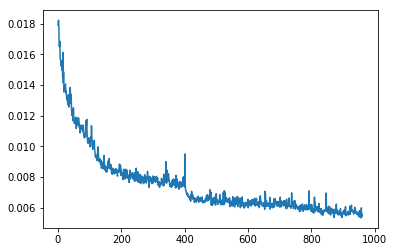

epoch: 994; mse: 0.00441; latent: 0.004; avg mse: 0.00443; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.83it/s]
epoch: 995; mse: 0.00454; latent: 0.004; avg mse: 0.00440; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.93it/s]
epoch: 996; mse: 0.00445; latent: 0.005; avg mse: 0.00444; lr: 0.00060: 100%|████████████| 3/3 [00:00<00:00,  3.10it/s]
epoch: 997; mse: 0.00447; latent: 0.005; avg mse: 0.00430; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.71it/s]
epoch: 998; mse: 0.00489; latent: 0.005; avg mse: 0.00476; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.92it/s]
epoch: 999; mse: 0.00441; latent: 0.005; avg mse: 0.00444; lr: 0.00060: 100%|████████████| 3/3 [00:01<00:00,  2.99it/s]
epoch: 1000; mse: 0.00486; latent: 0.005; avg mse: 0.00474; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.68it/s]
epoch: 1001; mse: 0.00470; latent: 0.005; avg mse: 0.00448; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.31it/s]
epoch: 1002; mse: 0.00412; latent: 0.004

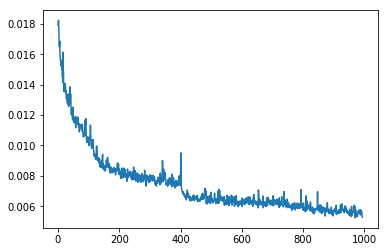

epoch: 1026; mse: 0.00427; latent: 0.004; avg mse: 0.00434; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 1027; mse: 0.00456; latent: 0.005; avg mse: 0.00453; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.85it/s]
epoch: 1028; mse: 0.00430; latent: 0.005; avg mse: 0.00435; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.88it/s]
epoch: 1029; mse: 0.00424; latent: 0.004; avg mse: 0.00435; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.86it/s]
epoch: 1030; mse: 0.00449; latent: 0.005; avg mse: 0.00437; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.15it/s]
epoch: 1031; mse: 0.00443; latent: 0.005; avg mse: 0.00454; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.59it/s]
epoch: 1032; mse: 0.00429; latent: 0.004; avg mse: 0.00439; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.23it/s]
epoch: 1033; mse: 0.00461; latent: 0.005; avg mse: 0.00447; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.48it/s]
epoch: 1034; mse: 0.00446; latent: 0.005

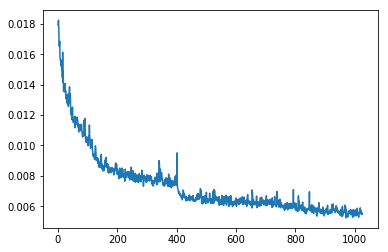

epoch: 1058; mse: 0.00440; latent: 0.005; avg mse: 0.00441; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.57it/s]
epoch: 1059; mse: 0.00453; latent: 0.005; avg mse: 0.00452; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.24it/s]
epoch: 1060; mse: 0.00431; latent: 0.004; avg mse: 0.00457; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.70it/s]
epoch: 1061; mse: 0.00425; latent: 0.004; avg mse: 0.00443; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 1062; mse: 0.00415; latent: 0.005; avg mse: 0.00451; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.77it/s]
epoch: 1063; mse: 0.00436; latent: 0.005; avg mse: 0.00442; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.76it/s]
epoch: 1064; mse: 0.00431; latent: 0.004; avg mse: 0.00436; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.18it/s]
epoch: 1065; mse: 0.00425; latent: 0.004; avg mse: 0.00432; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.47it/s]
epoch: 1066; mse: 0.00456; latent: 0.005

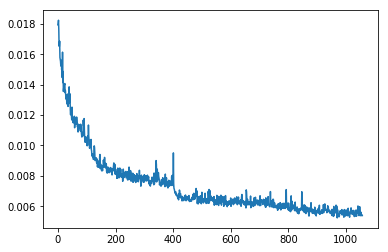

epoch: 1090; mse: 0.00431; latent: 0.004; avg mse: 0.00427; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.91it/s]
epoch: 1091; mse: 0.00424; latent: 0.004; avg mse: 0.00428; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 1092; mse: 0.00437; latent: 0.005; avg mse: 0.00440; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.24it/s]
epoch: 1093; mse: 0.00423; latent: 0.004; avg mse: 0.00427; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.58it/s]
epoch: 1094; mse: 0.00412; latent: 0.004; avg mse: 0.00427; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.58it/s]
epoch: 1095; mse: 0.00445; latent: 0.005; avg mse: 0.00438; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.55it/s]
epoch: 1096; mse: 0.00429; latent: 0.004; avg mse: 0.00424; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.45it/s]
epoch: 1097; mse: 0.00439; latent: 0.004; avg mse: 0.00432; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.58it/s]
epoch: 1098; mse: 0.00434; latent: 0.004

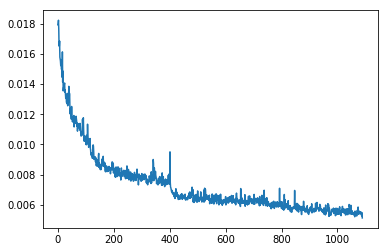

epoch: 1122; mse: 0.00455; latent: 0.005; avg mse: 0.00442; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.46it/s]
epoch: 1123; mse: 0.00499; latent: 0.005; avg mse: 0.00499; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.87it/s]
epoch: 1124; mse: 0.00445; latent: 0.004; avg mse: 0.00441; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.65it/s]
epoch: 1125; mse: 0.00443; latent: 0.005; avg mse: 0.00462; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.59it/s]
epoch: 1126; mse: 0.00450; latent: 0.005; avg mse: 0.00437; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.69it/s]
epoch: 1127; mse: 0.00435; latent: 0.005; avg mse: 0.00432; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.41it/s]
epoch: 1128; mse: 0.00425; latent: 0.005; avg mse: 0.00429; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.77it/s]
epoch: 1129; mse: 0.00416; latent: 0.004; avg mse: 0.00422; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.75it/s]
epoch: 1130; mse: 0.00432; latent: 0.004

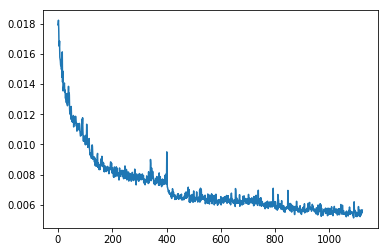

epoch: 1154; mse: 0.00418; latent: 0.004; avg mse: 0.00440; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.07it/s]
epoch: 1155; mse: 0.00423; latent: 0.004; avg mse: 0.00429; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.85it/s]
epoch: 1156; mse: 0.00465; latent: 0.004; avg mse: 0.00433; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.88it/s]
epoch: 1157; mse: 0.00444; latent: 0.004; avg mse: 0.00440; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.13it/s]
epoch: 1158; mse: 0.00432; latent: 0.004; avg mse: 0.00427; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 1159; mse: 0.00446; latent: 0.004; avg mse: 0.00453; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.33it/s]
epoch: 1160; mse: 0.00434; latent: 0.005; avg mse: 0.00438; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.51it/s]
epoch: 1161; mse: 0.00426; latent: 0.004; avg mse: 0.00451; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.09it/s]
epoch: 1162; mse: 0.00424; latent: 0.004

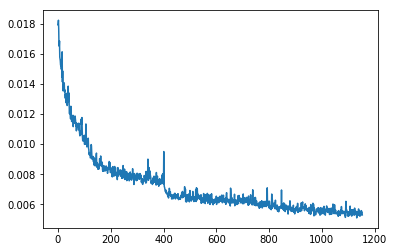

epoch: 1186; mse: 0.00428; latent: 0.004; avg mse: 0.00429; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.45it/s]
epoch: 1187; mse: 0.00418; latent: 0.004; avg mse: 0.00419; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.21it/s]
epoch: 1188; mse: 0.00443; latent: 0.004; avg mse: 0.00448; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.86it/s]
epoch: 1189; mse: 0.00428; latent: 0.004; avg mse: 0.00419; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.27it/s]
epoch: 1190; mse: 0.00445; latent: 0.004; avg mse: 0.00436; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.66it/s]
epoch: 1191; mse: 0.00441; latent: 0.004; avg mse: 0.00435; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.78it/s]
epoch: 1192; mse: 0.00440; latent: 0.004; avg mse: 0.00444; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  3.00it/s]
epoch: 1193; mse: 0.00425; latent: 0.004; avg mse: 0.00435; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.66it/s]
epoch: 1194; mse: 0.00425; latent: 0.004

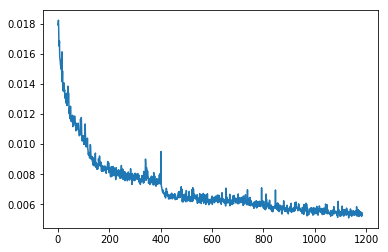

epoch: 1218; mse: 0.00414; latent: 0.004; avg mse: 0.00425; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.95it/s]
epoch: 1219; mse: 0.00423; latent: 0.004; avg mse: 0.00418; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 1220; mse: 0.00443; latent: 0.004; avg mse: 0.00426; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.12it/s]
epoch: 1221; mse: 0.00478; latent: 0.004; avg mse: 0.00448; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.65it/s]
epoch: 1222; mse: 0.00438; latent: 0.004; avg mse: 0.00443; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.70it/s]
epoch: 1223; mse: 0.00421; latent: 0.004; avg mse: 0.00425; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.22it/s]
epoch: 1224; mse: 0.00409; latent: 0.004; avg mse: 0.00432; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.80it/s]
epoch: 1225; mse: 0.00461; latent: 0.004; avg mse: 0.00436; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.14it/s]
epoch: 1226; mse: 0.00430; latent: 0.004

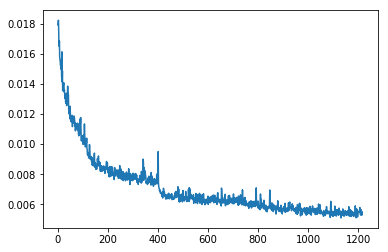

epoch: 1250; mse: 0.00408; latent: 0.004; avg mse: 0.00422; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.85it/s]
epoch: 1251; mse: 0.00442; latent: 0.004; avg mse: 0.00426; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 1252; mse: 0.00425; latent: 0.004; avg mse: 0.00429; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.01it/s]
epoch: 1253; mse: 0.00421; latent: 0.004; avg mse: 0.00430; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.54it/s]
epoch: 1254; mse: 0.00448; latent: 0.004; avg mse: 0.00428; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.28it/s]
epoch: 1255; mse: 0.00408; latent: 0.004; avg mse: 0.00415; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.43it/s]
epoch: 1256; mse: 0.00413; latent: 0.004; avg mse: 0.00425; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.33it/s]
epoch: 1257; mse: 0.00426; latent: 0.004; avg mse: 0.00418; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.45it/s]
epoch: 1258; mse: 0.00442; latent: 0.004

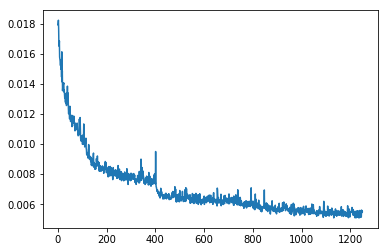

epoch: 1282; mse: 0.00492; latent: 0.004; avg mse: 0.00440; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.60it/s]
epoch: 1283; mse: 0.00459; latent: 0.004; avg mse: 0.00465; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.44it/s]
epoch: 1284; mse: 0.00460; latent: 0.005; avg mse: 0.00443; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 1285; mse: 0.00444; latent: 0.004; avg mse: 0.00456; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.26it/s]
epoch: 1286; mse: 0.00433; latent: 0.004; avg mse: 0.00427; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.52it/s]
epoch: 1287; mse: 0.00414; latent: 0.004; avg mse: 0.00427; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.07it/s]
epoch: 1288; mse: 0.00450; latent: 0.004; avg mse: 0.00440; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.70it/s]
epoch: 1289; mse: 0.00435; latent: 0.004; avg mse: 0.00423; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.65it/s]
epoch: 1290; mse: 0.00422; latent: 0.004

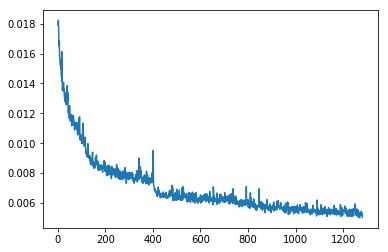

epoch: 1314; mse: 0.00437; latent: 0.004; avg mse: 0.00425; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 1315; mse: 0.00396; latent: 0.004; avg mse: 0.00422; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.84it/s]
epoch: 1316; mse: 0.00447; latent: 0.004; avg mse: 0.00429; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.99it/s]
epoch: 1317; mse: 0.00436; latent: 0.004; avg mse: 0.00443; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.69it/s]
epoch: 1318; mse: 0.00427; latent: 0.004; avg mse: 0.00421; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.88it/s]
epoch: 1319; mse: 0.00436; latent: 0.004; avg mse: 0.00446; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.73it/s]
epoch: 1320; mse: 0.00414; latent: 0.004; avg mse: 0.00423; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.21it/s]
epoch: 1321; mse: 0.00429; latent: 0.004; avg mse: 0.00421; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.90it/s]
epoch: 1322; mse: 0.00410; latent: 0.004

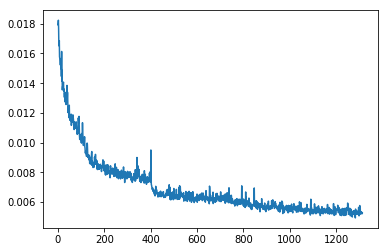

epoch: 1346; mse: 0.00408; latent: 0.004; avg mse: 0.00418; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.35it/s]
epoch: 1347; mse: 0.00460; latent: 0.004; avg mse: 0.00421; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.48it/s]
epoch: 1348; mse: 0.00408; latent: 0.004; avg mse: 0.00409; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.20it/s]
epoch: 1349; mse: 0.00419; latent: 0.004; avg mse: 0.00419; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.55it/s]
epoch: 1350; mse: 0.00382; latent: 0.004; avg mse: 0.00405; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 1351; mse: 0.00422; latent: 0.004; avg mse: 0.00419; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.19it/s]
epoch: 1352; mse: 0.00444; latent: 0.004; avg mse: 0.00429; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.76it/s]
epoch: 1353; mse: 0.00416; latent: 0.004; avg mse: 0.00422; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.13it/s]
epoch: 1354; mse: 0.00428; latent: 0.004

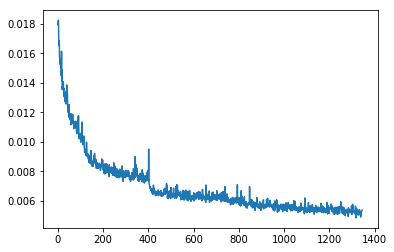

epoch: 1378; mse: 0.00423; latent: 0.004; avg mse: 0.00431; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.48it/s]
epoch: 1379; mse: 0.00397; latent: 0.004; avg mse: 0.00406; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.68it/s]
epoch: 1380; mse: 0.00415; latent: 0.004; avg mse: 0.00411; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.60it/s]
epoch: 1381; mse: 0.00407; latent: 0.004; avg mse: 0.00416; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.51it/s]
epoch: 1382; mse: 0.00417; latent: 0.004; avg mse: 0.00413; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.80it/s]
epoch: 1383; mse: 0.00446; latent: 0.004; avg mse: 0.00442; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.73it/s]
epoch: 1384; mse: 0.00410; latent: 0.004; avg mse: 0.00411; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.60it/s]
epoch: 1385; mse: 0.00418; latent: 0.004; avg mse: 0.00421; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.90it/s]
epoch: 1386; mse: 0.00416; latent: 0.004

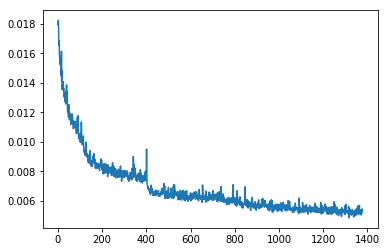

epoch: 1410; mse: 0.00407; latent: 0.004; avg mse: 0.00413; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.42it/s]
epoch: 1411; mse: 0.00417; latent: 0.004; avg mse: 0.00430; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.60it/s]
epoch: 1412; mse: 0.00423; latent: 0.004; avg mse: 0.00425; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.55it/s]
epoch: 1413; mse: 0.00424; latent: 0.004; avg mse: 0.00409; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.20it/s]
epoch: 1414; mse: 0.00405; latent: 0.004; avg mse: 0.00414; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.88it/s]
epoch: 1415; mse: 0.00436; latent: 0.004; avg mse: 0.00430; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.10it/s]
epoch: 1416; mse: 0.00415; latent: 0.004; avg mse: 0.00432; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.44it/s]
epoch: 1417; mse: 0.00452; latent: 0.004; avg mse: 0.00430; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.44it/s]
epoch: 1418; mse: 0.00407; latent: 0.004

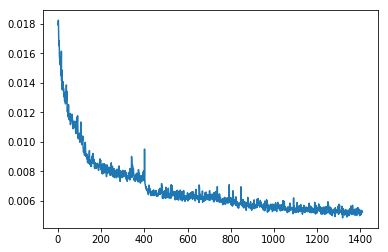

epoch: 1442; mse: 0.00415; latent: 0.004; avg mse: 0.00410; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 1443; mse: 0.00405; latent: 0.004; avg mse: 0.00413; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.19it/s]
epoch: 1444; mse: 0.00431; latent: 0.004; avg mse: 0.00416; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 1445; mse: 0.00436; latent: 0.004; avg mse: 0.00425; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.32it/s]
epoch: 1446; mse: 0.00426; latent: 0.004; avg mse: 0.00437; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.35it/s]
epoch: 1447; mse: 0.00439; latent: 0.004; avg mse: 0.00417; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.93it/s]
epoch: 1448; mse: 0.00428; latent: 0.004; avg mse: 0.00429; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.47it/s]
epoch: 1449; mse: 0.00409; latent: 0.004; avg mse: 0.00414; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.95it/s]
epoch: 1450; mse: 0.00400; latent: 0.004

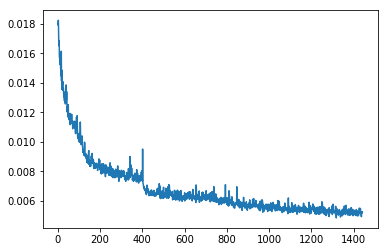

epoch: 1474; mse: 0.00412; latent: 0.004; avg mse: 0.00414; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.92it/s]
epoch: 1475; mse: 0.00419; latent: 0.004; avg mse: 0.00426; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 1476; mse: 0.00408; latent: 0.004; avg mse: 0.00409; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.84it/s]
epoch: 1477; mse: 0.00450; latent: 0.004; avg mse: 0.00419; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.28it/s]
epoch: 1478; mse: 0.00471; latent: 0.004; avg mse: 0.00448; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.81it/s]
epoch: 1479; mse: 0.00424; latent: 0.004; avg mse: 0.00419; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.98it/s]
epoch: 1480; mse: 0.00439; latent: 0.004; avg mse: 0.00430; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.63it/s]
epoch: 1481; mse: 0.00397; latent: 0.004; avg mse: 0.00410; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.39it/s]
epoch: 1482; mse: 0.00423; latent: 0.004

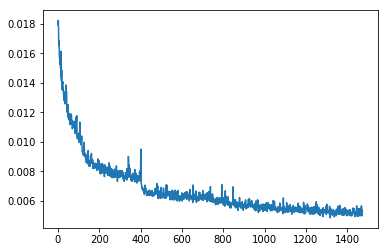

epoch: 1506; mse: 0.00423; latent: 0.004; avg mse: 0.00417; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.43it/s]
epoch: 1507; mse: 0.00405; latent: 0.004; avg mse: 0.00415; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.58it/s]
epoch: 1508; mse: 0.00410; latent: 0.004; avg mse: 0.00420; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.04it/s]
epoch: 1509; mse: 0.00416; latent: 0.004; avg mse: 0.00419; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.75it/s]
epoch: 1510; mse: 0.00401; latent: 0.004; avg mse: 0.00412; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.96it/s]
epoch: 1511; mse: 0.00426; latent: 0.004; avg mse: 0.00417; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.81it/s]
epoch: 1512; mse: 0.00423; latent: 0.004; avg mse: 0.00423; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.57it/s]
epoch: 1513; mse: 0.00421; latent: 0.004; avg mse: 0.00416; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.93it/s]
epoch: 1514; mse: 0.00415; latent: 0.004

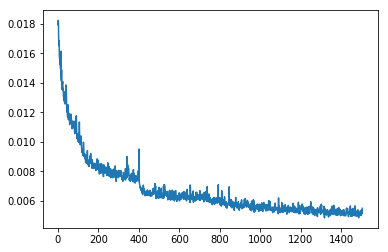

epoch: 1538; mse: 0.00450; latent: 0.004; avg mse: 0.00427; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 1539; mse: 0.00409; latent: 0.004; avg mse: 0.00418; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.65it/s]
epoch: 1540; mse: 0.00415; latent: 0.004; avg mse: 0.00419; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.47it/s]
epoch: 1541; mse: 0.00411; latent: 0.004; avg mse: 0.00423; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.46it/s]
epoch: 1542; mse: 0.00404; latent: 0.004; avg mse: 0.00409; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.60it/s]
epoch: 1543; mse: 0.00423; latent: 0.004; avg mse: 0.00412; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.61it/s]
epoch: 1544; mse: 0.00401; latent: 0.004; avg mse: 0.00412; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.21it/s]
epoch: 1545; mse: 0.00412; latent: 0.004; avg mse: 0.00404; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.48it/s]
epoch: 1546; mse: 0.00382; latent: 0.004

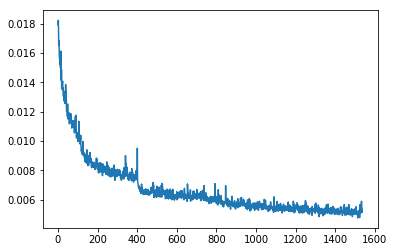

epoch: 1570; mse: 0.00418; latent: 0.004; avg mse: 0.00415; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.56it/s]
epoch: 1571; mse: 0.00408; latent: 0.004; avg mse: 0.00415; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.29it/s]
epoch: 1572; mse: 0.00428; latent: 0.004; avg mse: 0.00418; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.79it/s]
epoch: 1573; mse: 0.00424; latent: 0.004; avg mse: 0.00405; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.25it/s]
epoch: 1574; mse: 0.00411; latent: 0.004; avg mse: 0.00408; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.79it/s]
epoch: 1575; mse: 0.00400; latent: 0.004; avg mse: 0.00413; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.11it/s]
epoch: 1576; mse: 0.00418; latent: 0.004; avg mse: 0.00419; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.71it/s]
epoch: 1577; mse: 0.00413; latent: 0.004; avg mse: 0.00406; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.13it/s]
epoch: 1578; mse: 0.00400; latent: 0.004

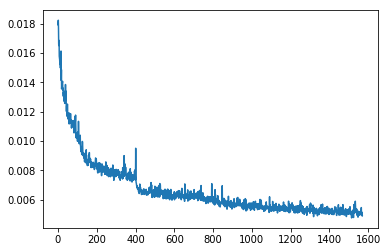

epoch: 1602; mse: 0.00396; latent: 0.004; avg mse: 0.00399; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.70it/s]
epoch: 1603; mse: 0.00425; latent: 0.004; avg mse: 0.00403; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.04it/s]
epoch: 1604; mse: 0.00403; latent: 0.004; avg mse: 0.00405; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 1605; mse: 0.00438; latent: 0.004; avg mse: 0.00429; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 1606; mse: 0.00435; latent: 0.004; avg mse: 0.00449; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.82it/s]
epoch: 1607; mse: 0.00433; latent: 0.004; avg mse: 0.00413; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.12it/s]
epoch: 1608; mse: 0.00399; latent: 0.004; avg mse: 0.00424; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.86it/s]
epoch: 1609; mse: 0.00409; latent: 0.004; avg mse: 0.00413; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.69it/s]
epoch: 1610; mse: 0.00409; latent: 0.004

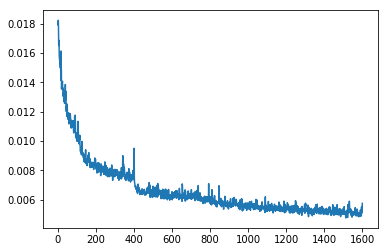

epoch: 1634; mse: 0.00425; latent: 0.004; avg mse: 0.00431; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.37it/s]
epoch: 1635; mse: 0.00413; latent: 0.004; avg mse: 0.00417; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.45it/s]
epoch: 1636; mse: 0.00433; latent: 0.004; avg mse: 0.00432; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.56it/s]
epoch: 1637; mse: 0.00406; latent: 0.004; avg mse: 0.00436; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.42it/s]
epoch: 1638; mse: 0.00424; latent: 0.004; avg mse: 0.00410; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.55it/s]
epoch: 1639; mse: 0.00396; latent: 0.004; avg mse: 0.00417; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.53it/s]
epoch: 1640; mse: 0.00436; latent: 0.004; avg mse: 0.00429; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 1641; mse: 0.00417; latent: 0.004; avg mse: 0.00419; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.43it/s]
epoch: 1642; mse: 0.00414; latent: 0.004

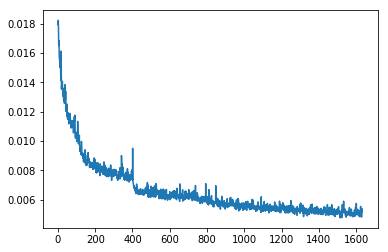

epoch: 1666; mse: 0.00405; latent: 0.004; avg mse: 0.00415; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.62it/s]
epoch: 1667; mse: 0.00407; latent: 0.004; avg mse: 0.00417; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.58it/s]
epoch: 1668; mse: 0.00405; latent: 0.004; avg mse: 0.00398; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 1669; mse: 0.00409; latent: 0.004; avg mse: 0.00407; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.91it/s]
epoch: 1670; mse: 0.00401; latent: 0.004; avg mse: 0.00400; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 1671; mse: 0.00410; latent: 0.004; avg mse: 0.00398; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.90it/s]
epoch: 1672; mse: 0.00388; latent: 0.004; avg mse: 0.00402; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.63it/s]
epoch: 1673; mse: 0.00403; latent: 0.004; avg mse: 0.00406; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.58it/s]
epoch: 1674; mse: 0.00413; latent: 0.004

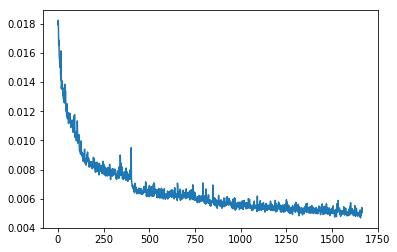

epoch: 1698; mse: 0.00399; latent: 0.004; avg mse: 0.00409; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.75it/s]
epoch: 1699; mse: 0.00421; latent: 0.004; avg mse: 0.00406; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.83it/s]
epoch: 1700; mse: 0.00419; latent: 0.004; avg mse: 0.00429; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 1701; mse: 0.00439; latent: 0.004; avg mse: 0.00415; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.91it/s]
epoch: 1702; mse: 0.00404; latent: 0.004; avg mse: 0.00418; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.77it/s]
epoch: 1703; mse: 0.00424; latent: 0.004; avg mse: 0.00431; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.62it/s]
epoch: 1704; mse: 0.00400; latent: 0.004; avg mse: 0.00420; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.07it/s]
epoch: 1705; mse: 0.00410; latent: 0.004; avg mse: 0.00418; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.79it/s]
epoch: 1706; mse: 0.00400; latent: 0.004

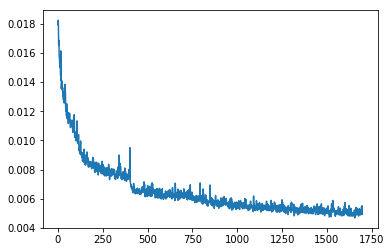

epoch: 1730; mse: 0.00394; latent: 0.004; avg mse: 0.00409; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.04it/s]
epoch: 1731; mse: 0.00418; latent: 0.004; avg mse: 0.00403; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.82it/s]
epoch: 1732; mse: 0.00396; latent: 0.004; avg mse: 0.00400; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.86it/s]
epoch: 1733; mse: 0.00415; latent: 0.004; avg mse: 0.00406; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.94it/s]
epoch: 1734; mse: 0.00400; latent: 0.004; avg mse: 0.00397; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.71it/s]
epoch: 1735; mse: 0.00398; latent: 0.004; avg mse: 0.00405; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.93it/s]
epoch: 1736; mse: 0.00413; latent: 0.004; avg mse: 0.00414; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.68it/s]
epoch: 1737; mse: 0.00391; latent: 0.004; avg mse: 0.00409; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.08it/s]
epoch: 1738; mse: 0.00396; latent: 0.004

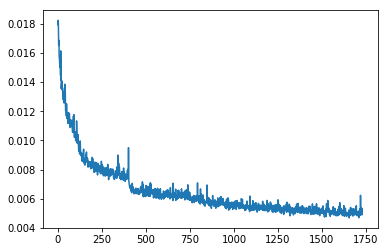

epoch: 1762; mse: 0.00422; latent: 0.004; avg mse: 0.00414; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.80it/s]
epoch: 1763; mse: 0.00404; latent: 0.004; avg mse: 0.00420; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.84it/s]
epoch: 1764; mse: 0.00384; latent: 0.004; avg mse: 0.00397; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.08it/s]
epoch: 1765; mse: 0.00396; latent: 0.004; avg mse: 0.00416; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.73it/s]
epoch: 1766; mse: 0.00412; latent: 0.004; avg mse: 0.00402; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.46it/s]
epoch: 1767; mse: 0.00398; latent: 0.004; avg mse: 0.00400; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.55it/s]
epoch: 1768; mse: 0.00411; latent: 0.004; avg mse: 0.00401; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.22it/s]
epoch: 1769; mse: 0.00397; latent: 0.004; avg mse: 0.00410; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.57it/s]
epoch: 1770; mse: 0.00387; latent: 0.004

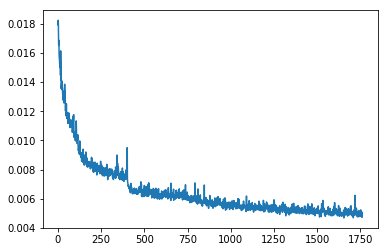

epoch: 1794; mse: 0.00430; latent: 0.004; avg mse: 0.00402; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.86it/s]
epoch: 1795; mse: 0.00433; latent: 0.004; avg mse: 0.00426; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.83it/s]
epoch: 1796; mse: 0.00390; latent: 0.004; avg mse: 0.00407; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.15it/s]
epoch: 1797; mse: 0.00431; latent: 0.004; avg mse: 0.00428; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.84it/s]
epoch: 1798; mse: 0.00432; latent: 0.004; avg mse: 0.00413; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.97it/s]
epoch: 1799; mse: 0.00399; latent: 0.004; avg mse: 0.00412; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.82it/s]
epoch: 1800; mse: 0.00403; latent: 0.004; avg mse: 0.00408; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.07it/s]
epoch: 1801; mse: 0.00392; latent: 0.004; avg mse: 0.00397; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 1802; mse: 0.00401; latent: 0.003

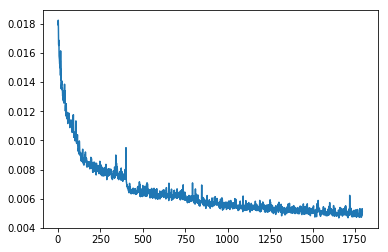

epoch: 1826; mse: 0.00385; latent: 0.003; avg mse: 0.00402; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.45it/s]
epoch: 1827; mse: 0.00404; latent: 0.004; avg mse: 0.00399; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 1828; mse: 0.00423; latent: 0.004; avg mse: 0.00411; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.50it/s]
epoch: 1829; mse: 0.00403; latent: 0.004; avg mse: 0.00402; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.57it/s]
epoch: 1830; mse: 0.00385; latent: 0.004; avg mse: 0.00399; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.22it/s]
epoch: 1831; mse: 0.00381; latent: 0.004; avg mse: 0.00400; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.62it/s]
epoch: 1832; mse: 0.00403; latent: 0.004; avg mse: 0.00401; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.33it/s]
epoch: 1833; mse: 0.00422; latent: 0.004; avg mse: 0.00412; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.56it/s]
epoch: 1834; mse: 0.00411; latent: 0.004

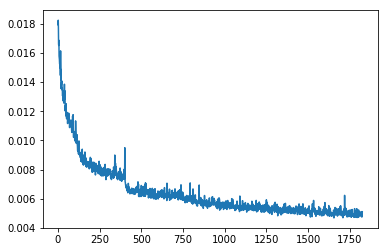

epoch: 1858; mse: 0.00406; latent: 0.004; avg mse: 0.00410; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.55it/s]
epoch: 1859; mse: 0.00404; latent: 0.004; avg mse: 0.00414; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.28it/s]
epoch: 1860; mse: 0.00438; latent: 0.003; avg mse: 0.00419; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 1861; mse: 0.00389; latent: 0.004; avg mse: 0.00408; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.50it/s]
epoch: 1862; mse: 0.00422; latent: 0.004; avg mse: 0.00405; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.80it/s]
epoch: 1863; mse: 0.00398; latent: 0.004; avg mse: 0.00404; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.40it/s]
epoch: 1864; mse: 0.00409; latent: 0.004; avg mse: 0.00410; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.43it/s]
epoch: 1865; mse: 0.00402; latent: 0.004; avg mse: 0.00405; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.04it/s]
epoch: 1866; mse: 0.00404; latent: 0.004

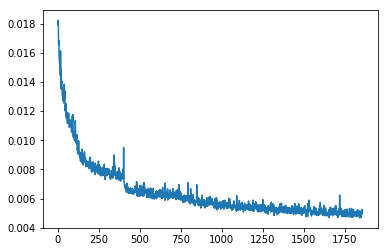

epoch: 1890; mse: 0.00405; latent: 0.004; avg mse: 0.00401; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.69it/s]
epoch: 1891; mse: 0.00400; latent: 0.004; avg mse: 0.00399; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.16it/s]
epoch: 1892; mse: 0.00395; latent: 0.004; avg mse: 0.00403; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.66it/s]
epoch: 1893; mse: 0.00407; latent: 0.004; avg mse: 0.00394; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.39it/s]
epoch: 1894; mse: 0.00382; latent: 0.004; avg mse: 0.00391; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.69it/s]
epoch: 1895; mse: 0.00392; latent: 0.004; avg mse: 0.00391; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.08it/s]
epoch: 1896; mse: 0.00409; latent: 0.004; avg mse: 0.00390; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.03it/s]
epoch: 1897; mse: 0.00399; latent: 0.004; avg mse: 0.00404; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.95it/s]
epoch: 1898; mse: 0.00397; latent: 0.004

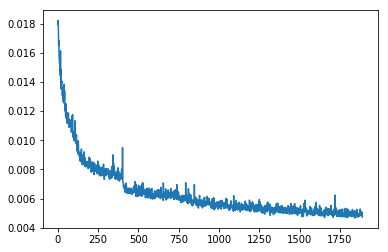

epoch: 1922; mse: 0.00419; latent: 0.004; avg mse: 0.00412; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.70it/s]
epoch: 1923; mse: 0.00387; latent: 0.004; avg mse: 0.00393; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.13it/s]
epoch: 1924; mse: 0.00409; latent: 0.004; avg mse: 0.00401; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.48it/s]
epoch: 1925; mse: 0.00395; latent: 0.003; avg mse: 0.00392; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.01it/s]
epoch: 1926; mse: 0.00404; latent: 0.004; avg mse: 0.00414; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  1.78it/s]
epoch: 1927; mse: 0.00398; latent: 0.004; avg mse: 0.00399; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.15it/s]
epoch: 1928; mse: 0.00391; latent: 0.004; avg mse: 0.00412; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.71it/s]
epoch: 1929; mse: 0.00408; latent: 0.003; avg mse: 0.00395; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.41it/s]
epoch: 1930; mse: 0.00399; latent: 0.004

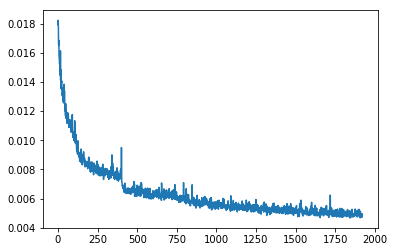

epoch: 1954; mse: 0.00397; latent: 0.004; avg mse: 0.00389; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 1955; mse: 0.00396; latent: 0.004; avg mse: 0.00388; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.70it/s]
epoch: 1956; mse: 0.00410; latent: 0.004; avg mse: 0.00411; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.58it/s]
epoch: 1957; mse: 0.00400; latent: 0.004; avg mse: 0.00388; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.59it/s]
epoch: 1958; mse: 0.00394; latent: 0.004; avg mse: 0.00410; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.79it/s]
epoch: 1959; mse: 0.00407; latent: 0.003; avg mse: 0.00406; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.70it/s]
epoch: 1960; mse: 0.00391; latent: 0.004; avg mse: 0.00398; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.63it/s]
epoch: 1961; mse: 0.00407; latent: 0.004; avg mse: 0.00395; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.53it/s]
epoch: 1962; mse: 0.00402; latent: 0.004

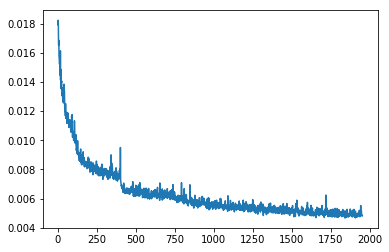

epoch: 1986; mse: 0.00417; latent: 0.004; avg mse: 0.00403; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 1987; mse: 0.00379; latent: 0.004; avg mse: 0.00390; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.83it/s]
epoch: 1988; mse: 0.00382; latent: 0.004; avg mse: 0.00397; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.89it/s]
epoch: 1989; mse: 0.00434; latent: 0.004; avg mse: 0.00404; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.67it/s]
epoch: 1990; mse: 0.00394; latent: 0.003; avg mse: 0.00413; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.18it/s]
epoch: 1991; mse: 0.00394; latent: 0.004; avg mse: 0.00391; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.79it/s]
epoch: 1992; mse: 0.00387; latent: 0.004; avg mse: 0.00397; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.16it/s]
epoch: 1993; mse: 0.00393; latent: 0.004; avg mse: 0.00399; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.71it/s]
epoch: 1994; mse: 0.00402; latent: 0.004

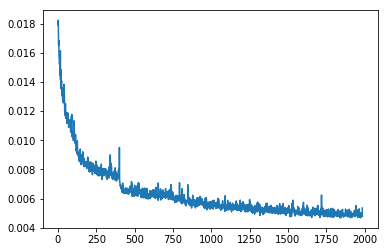

epoch: 2018; mse: 0.00384; latent: 0.003; avg mse: 0.00399; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.75it/s]
epoch: 2019; mse: 0.00375; latent: 0.004; avg mse: 0.00393; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.01it/s]
epoch: 2020; mse: 0.00382; latent: 0.003; avg mse: 0.00404; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.99it/s]
epoch: 2021; mse: 0.00409; latent: 0.004; avg mse: 0.00399; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.78it/s]
epoch: 2022; mse: 0.00422; latent: 0.004; avg mse: 0.00404; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.12it/s]
epoch: 2023; mse: 0.00431; latent: 0.004; avg mse: 0.00420; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.39it/s]
epoch: 2024; mse: 0.00385; latent: 0.003; avg mse: 0.00398; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.20it/s]
epoch: 2025; mse: 0.00405; latent: 0.004; avg mse: 0.00411; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 2026; mse: 0.00385; latent: 0.003

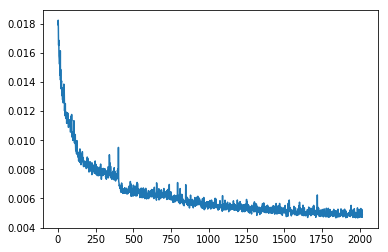

epoch: 2050; mse: 0.00403; latent: 0.003; avg mse: 0.00405; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.50it/s]
epoch: 2051; mse: 0.00386; latent: 0.003; avg mse: 0.00390; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.91it/s]
epoch: 2052; mse: 0.00418; latent: 0.004; avg mse: 0.00397; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.85it/s]
epoch: 2053; mse: 0.00400; latent: 0.004; avg mse: 0.00403; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.71it/s]
epoch: 2054; mse: 0.00407; latent: 0.003; avg mse: 0.00391; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.09it/s]
epoch: 2055; mse: 0.00404; latent: 0.004; avg mse: 0.00388; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.76it/s]
epoch: 2056; mse: 0.00400; latent: 0.004; avg mse: 0.00389; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.04it/s]
epoch: 2057; mse: 0.00390; latent: 0.004; avg mse: 0.00391; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.50it/s]
epoch: 2058; mse: 0.00416; latent: 0.004

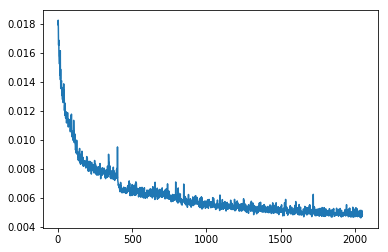

epoch: 2082; mse: 0.00383; latent: 0.003; avg mse: 0.00393; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.52it/s]
epoch: 2083; mse: 0.00410; latent: 0.003; avg mse: 0.00387; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.14it/s]
epoch: 2084; mse: 0.00390; latent: 0.004; avg mse: 0.00397; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.50it/s]
epoch: 2085; mse: 0.00480; latent: 0.004; avg mse: 0.00453; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.27it/s]
epoch: 2086; mse: 0.00411; latent: 0.004; avg mse: 0.00438; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.87it/s]
epoch: 2087; mse: 0.00466; latent: 0.004; avg mse: 0.00477; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.29it/s]
epoch: 2088; mse: 0.00424; latent: 0.005; avg mse: 0.00428; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.86it/s]
epoch: 2089; mse: 0.00475; latent: 0.004; avg mse: 0.00479; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 2090; mse: 0.00419; latent: 0.004

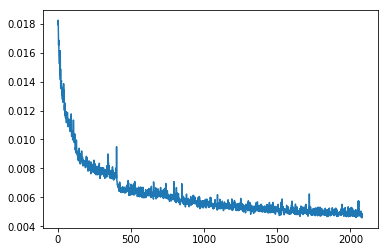

epoch: 2114; mse: 0.00391; latent: 0.004; avg mse: 0.00391; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.03it/s]
epoch: 2115; mse: 0.00386; latent: 0.004; avg mse: 0.00384; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.96it/s]
epoch: 2116; mse: 0.00383; latent: 0.003; avg mse: 0.00400; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.07it/s]
epoch: 2117; mse: 0.00379; latent: 0.003; avg mse: 0.00398; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.76it/s]
epoch: 2118; mse: 0.00367; latent: 0.003; avg mse: 0.00381; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.98it/s]
epoch: 2119; mse: 0.00388; latent: 0.004; avg mse: 0.00388; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.83it/s]
epoch: 2120; mse: 0.00407; latent: 0.004; avg mse: 0.00406; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.10it/s]
epoch: 2121; mse: 0.00382; latent: 0.003; avg mse: 0.00422; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.85it/s]
epoch: 2122; mse: 0.00418; latent: 0.004

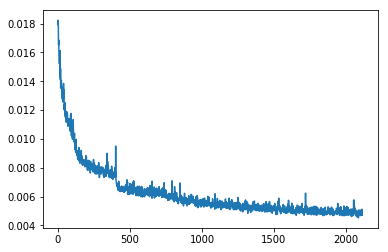

epoch: 2146; mse: 0.00388; latent: 0.003; avg mse: 0.00411; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.69it/s]
epoch: 2147; mse: 0.00404; latent: 0.004; avg mse: 0.00401; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.09it/s]
epoch: 2148; mse: 0.00382; latent: 0.004; avg mse: 0.00392; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.66it/s]
epoch: 2149; mse: 0.00401; latent: 0.003; avg mse: 0.00402; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.20it/s]
epoch: 2150; mse: 0.00405; latent: 0.004; avg mse: 0.00403; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.43it/s]
epoch: 2151; mse: 0.00389; latent: 0.004; avg mse: 0.00411; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.46it/s]
epoch: 2152; mse: 0.00399; latent: 0.004; avg mse: 0.00390; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.41it/s]
epoch: 2153; mse: 0.00391; latent: 0.004; avg mse: 0.00397; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.23it/s]
epoch: 2154; mse: 0.00387; latent: 0.003

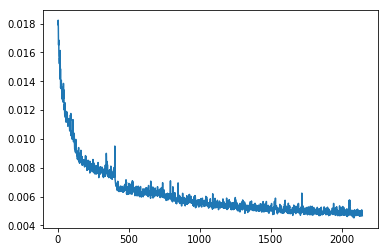

epoch: 2178; mse: 0.00409; latent: 0.004; avg mse: 0.00417; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.65it/s]
epoch: 2179; mse: 0.00392; latent: 0.004; avg mse: 0.00398; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.32it/s]
epoch: 2180; mse: 0.00459; latent: 0.003; avg mse: 0.00431; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 2181; mse: 0.00404; latent: 0.004; avg mse: 0.00395; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.80it/s]
epoch: 2182; mse: 0.00389; latent: 0.004; avg mse: 0.00414; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.12it/s]
epoch: 2183; mse: 0.00414; latent: 0.003; avg mse: 0.00421; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.73it/s]
epoch: 2184; mse: 0.00429; latent: 0.004; avg mse: 0.00397; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.18it/s]
epoch: 2185; mse: 0.00412; latent: 0.004; avg mse: 0.00403; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.45it/s]
epoch: 2186; mse: 0.00422; latent: 0.004

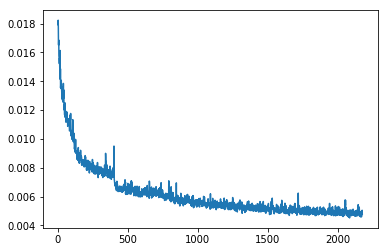

epoch: 2210; mse: 0.00395; latent: 0.004; avg mse: 0.00407; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 2211; mse: 0.00389; latent: 0.004; avg mse: 0.00385; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.45it/s]
epoch: 2212; mse: 0.00402; latent: 0.004; avg mse: 0.00396; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.73it/s]
epoch: 2213; mse: 0.00393; latent: 0.003; avg mse: 0.00390; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.51it/s]
epoch: 2214; mse: 0.00395; latent: 0.003; avg mse: 0.00395; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.33it/s]
epoch: 2215; mse: 0.00382; latent: 0.003; avg mse: 0.00396; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 2216; mse: 0.00363; latent: 0.003; avg mse: 0.00382; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.60it/s]
epoch: 2217; mse: 0.00402; latent: 0.004; avg mse: 0.00390; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.61it/s]
epoch: 2218; mse: 0.00397; latent: 0.003

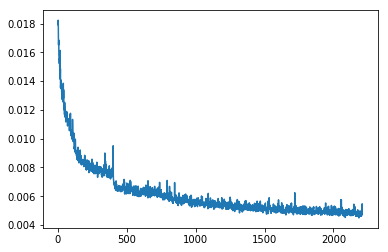

epoch: 2242; mse: 0.00445; latent: 0.004; avg mse: 0.00442; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 2243; mse: 0.00400; latent: 0.004; avg mse: 0.00410; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.43it/s]
epoch: 2244; mse: 0.00384; latent: 0.004; avg mse: 0.00408; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.39it/s]
epoch: 2245; mse: 0.00385; latent: 0.004; avg mse: 0.00406; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.11it/s]
epoch: 2246; mse: 0.00381; latent: 0.003; avg mse: 0.00392; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.68it/s]
epoch: 2247; mse: 0.00389; latent: 0.003; avg mse: 0.00392; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.31it/s]
epoch: 2248; mse: 0.00402; latent: 0.004; avg mse: 0.00396; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.57it/s]
epoch: 2249; mse: 0.00390; latent: 0.003; avg mse: 0.00387; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.11it/s]
epoch: 2250; mse: 0.00406; latent: 0.004

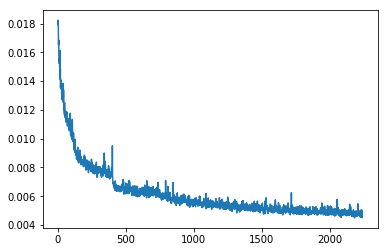

epoch: 2274; mse: 0.00375; latent: 0.003; avg mse: 0.00397; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.16it/s]
epoch: 2275; mse: 0.00422; latent: 0.003; avg mse: 0.00405; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.51it/s]
epoch: 2276; mse: 0.00371; latent: 0.003; avg mse: 0.00404; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.37it/s]
epoch: 2277; mse: 0.00393; latent: 0.003; avg mse: 0.00393; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.59it/s]
epoch: 2278; mse: 0.00397; latent: 0.004; avg mse: 0.00388; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.19it/s]
epoch: 2279; mse: 0.00385; latent: 0.003; avg mse: 0.00398; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.83it/s]
epoch: 2280; mse: 0.00415; latent: 0.003; avg mse: 0.00399; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.15it/s]
epoch: 2281; mse: 0.00386; latent: 0.004; avg mse: 0.00379; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.82it/s]
epoch: 2282; mse: 0.00407; latent: 0.003

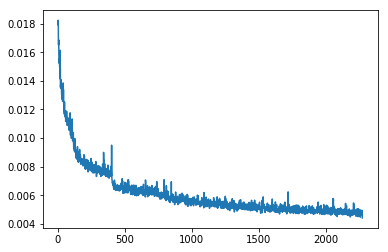

epoch: 2306; mse: 0.00388; latent: 0.004; avg mse: 0.00383; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.23it/s]
epoch: 2307; mse: 0.00414; latent: 0.003; avg mse: 0.00406; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.96it/s]
epoch: 2308; mse: 0.00395; latent: 0.003; avg mse: 0.00394; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.59it/s]
epoch: 2309; mse: 0.00398; latent: 0.004; avg mse: 0.00382; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.23it/s]
epoch: 2310; mse: 0.00397; latent: 0.003; avg mse: 0.00392; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.82it/s]
epoch: 2311; mse: 0.00383; latent: 0.004; avg mse: 0.00393; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 2312; mse: 0.00383; latent: 0.004; avg mse: 0.00397; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.60it/s]
epoch: 2313; mse: 0.00398; latent: 0.003; avg mse: 0.00384; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.33it/s]
epoch: 2314; mse: 0.00390; latent: 0.003

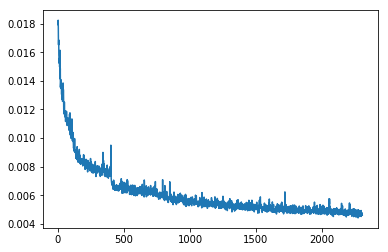

epoch: 2338; mse: 0.00395; latent: 0.004; avg mse: 0.00384; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.95it/s]
epoch: 2339; mse: 0.00394; latent: 0.004; avg mse: 0.00387; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.04it/s]
epoch: 2340; mse: 0.00396; latent: 0.003; avg mse: 0.00392; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.73it/s]
epoch: 2341; mse: 0.00382; latent: 0.004; avg mse: 0.00377; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.03it/s]
epoch: 2342; mse: 0.00379; latent: 0.003; avg mse: 0.00392; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.81it/s]
epoch: 2343; mse: 0.00407; latent: 0.003; avg mse: 0.00417; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.41it/s]
epoch: 2344; mse: 0.00374; latent: 0.003; avg mse: 0.00390; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.58it/s]
epoch: 2345; mse: 0.00384; latent: 0.004; avg mse: 0.00384; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.83it/s]
epoch: 2346; mse: 0.00371; latent: 0.003

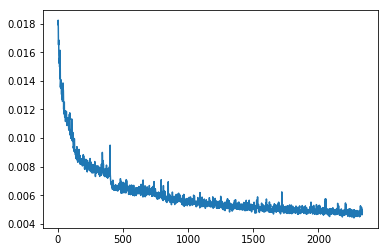

epoch: 2370; mse: 0.00420; latent: 0.003; avg mse: 0.00398; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.53it/s]
epoch: 2371; mse: 0.00394; latent: 0.003; avg mse: 0.00387; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.45it/s]
epoch: 2372; mse: 0.00386; latent: 0.004; avg mse: 0.00385; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.56it/s]
epoch: 2373; mse: 0.00385; latent: 0.004; avg mse: 0.00402; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.25it/s]
epoch: 2374; mse: 0.00393; latent: 0.003; avg mse: 0.00390; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.51it/s]
epoch: 2375; mse: 0.00396; latent: 0.003; avg mse: 0.00397; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.20it/s]
epoch: 2376; mse: 0.00398; latent: 0.004; avg mse: 0.00389; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 2377; mse: 0.00405; latent: 0.003; avg mse: 0.00391; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.29it/s]
epoch: 2378; mse: 0.00388; latent: 0.003

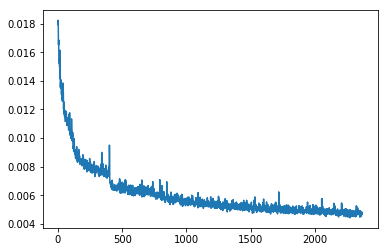

epoch: 2402; mse: 0.00411; latent: 0.004; avg mse: 0.00388; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.93it/s]
epoch: 2403; mse: 0.00403; latent: 0.004; avg mse: 0.00402; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.89it/s]
epoch: 2404; mse: 0.00384; latent: 0.004; avg mse: 0.00386; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.84it/s]
epoch: 2405; mse: 0.00369; latent: 0.003; avg mse: 0.00387; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 2406; mse: 0.00374; latent: 0.003; avg mse: 0.00376; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.06it/s]
epoch: 2407; mse: 0.00392; latent: 0.003; avg mse: 0.00388; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 2408; mse: 0.00383; latent: 0.003; avg mse: 0.00379; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.90it/s]
epoch: 2409; mse: 0.00375; latent: 0.003; avg mse: 0.00374; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.96it/s]
epoch: 2410; mse: 0.00388; latent: 0.003

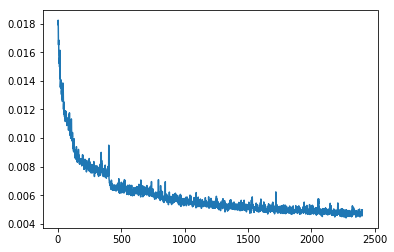

epoch: 2434; mse: 0.00378; latent: 0.003; avg mse: 0.00391; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.41it/s]
epoch: 2435; mse: 0.00399; latent: 0.003; avg mse: 0.00393; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.41it/s]
epoch: 2436; mse: 0.00379; latent: 0.003; avg mse: 0.00388; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.20it/s]
epoch: 2437; mse: 0.00414; latent: 0.003; avg mse: 0.00398; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.61it/s]
epoch: 2438; mse: 0.00419; latent: 0.004; avg mse: 0.00389; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.43it/s]
epoch: 2439; mse: 0.00382; latent: 0.003; avg mse: 0.00403; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.55it/s]
epoch: 2440; mse: 0.00395; latent: 0.003; avg mse: 0.00387; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.29it/s]
epoch: 2441; mse: 0.00399; latent: 0.003; avg mse: 0.00386; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.76it/s]
epoch: 2442; mse: 0.00390; latent: 0.004

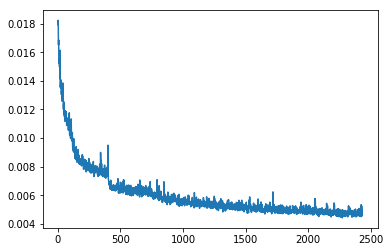

epoch: 2466; mse: 0.00406; latent: 0.004; avg mse: 0.00395; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.61it/s]
epoch: 2467; mse: 0.00377; latent: 0.004; avg mse: 0.00387; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.12it/s]
epoch: 2468; mse: 0.00403; latent: 0.003; avg mse: 0.00405; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.68it/s]
epoch: 2469; mse: 0.00397; latent: 0.003; avg mse: 0.00391; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.88it/s]
epoch: 2470; mse: 0.00398; latent: 0.003; avg mse: 0.00388; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 2471; mse: 0.00393; latent: 0.003; avg mse: 0.00397; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.84it/s]
epoch: 2472; mse: 0.00372; latent: 0.004; avg mse: 0.00381; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 2473; mse: 0.00394; latent: 0.003; avg mse: 0.00383; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.90it/s]
epoch: 2474; mse: 0.00380; latent: 0.003

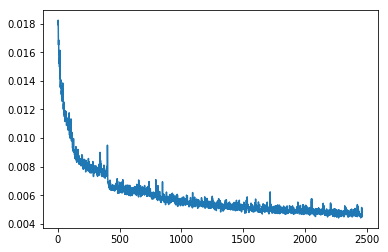

epoch: 2498; mse: 0.00396; latent: 0.003; avg mse: 0.00391; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.60it/s]
epoch: 2499; mse: 0.00378; latent: 0.003; avg mse: 0.00383; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.46it/s]
epoch: 2500; mse: 0.00373; latent: 0.003; avg mse: 0.00381; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.88it/s]
epoch: 2501; mse: 0.00388; latent: 0.004; avg mse: 0.00382; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.60it/s]
epoch: 2502; mse: 0.00384; latent: 0.003; avg mse: 0.00388; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 2503; mse: 0.00400; latent: 0.003; avg mse: 0.00385; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.57it/s]
epoch: 2504; mse: 0.00386; latent: 0.003; avg mse: 0.00378; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.61it/s]
epoch: 2505; mse: 0.00386; latent: 0.003; avg mse: 0.00382; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.45it/s]
epoch: 2506; mse: 0.00404; latent: 0.003

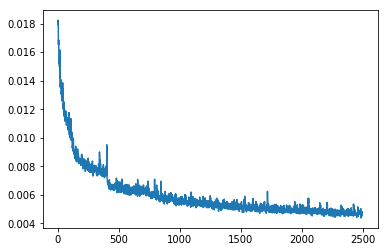

epoch: 2530; mse: 0.00395; latent: 0.004; avg mse: 0.00394; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.14it/s]
epoch: 2531; mse: 0.00389; latent: 0.003; avg mse: 0.00387; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 2532; mse: 0.00399; latent: 0.003; avg mse: 0.00408; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.76it/s]
epoch: 2533; mse: 0.00450; latent: 0.003; avg mse: 0.00408; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.82it/s]
epoch: 2534; mse: 0.00383; latent: 0.003; avg mse: 0.00403; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.63it/s]
epoch: 2535; mse: 0.00384; latent: 0.003; avg mse: 0.00390; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.98it/s]
epoch: 2536; mse: 0.00377; latent: 0.003; avg mse: 0.00375; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.82it/s]
epoch: 2537; mse: 0.00381; latent: 0.003; avg mse: 0.00374; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.14it/s]
epoch: 2538; mse: 0.00388; latent: 0.003

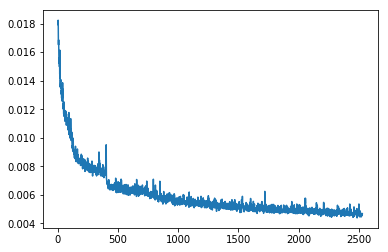

epoch: 2562; mse: 0.00376; latent: 0.003; avg mse: 0.00382; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.53it/s]
epoch: 2563; mse: 0.00393; latent: 0.003; avg mse: 0.00381; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.52it/s]
epoch: 2564; mse: 0.00367; latent: 0.003; avg mse: 0.00379; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.05it/s]
epoch: 2565; mse: 0.00384; latent: 0.003; avg mse: 0.00380; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.46it/s]
epoch: 2566; mse: 0.00388; latent: 0.003; avg mse: 0.00395; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.34it/s]
epoch: 2567; mse: 0.00380; latent: 0.003; avg mse: 0.00391; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.21it/s]
epoch: 2568; mse: 0.00382; latent: 0.003; avg mse: 0.00378; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.71it/s]
epoch: 2569; mse: 0.00388; latent: 0.003; avg mse: 0.00389; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.83it/s]
epoch: 2570; mse: 0.00364; latent: 0.003

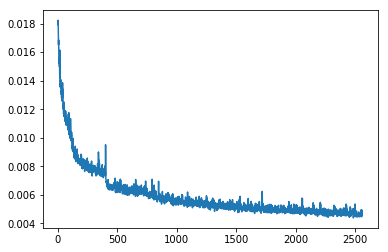

epoch: 2594; mse: 0.00384; latent: 0.003; avg mse: 0.00388; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.35it/s]
epoch: 2595; mse: 0.00377; latent: 0.003; avg mse: 0.00392; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.45it/s]
epoch: 2596; mse: 0.00384; latent: 0.003; avg mse: 0.00396; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.16it/s]
epoch: 2597; mse: 0.00401; latent: 0.003; avg mse: 0.00391; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.62it/s]
epoch: 2598; mse: 0.00380; latent: 0.003; avg mse: 0.00387; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.86it/s]
epoch: 2599; mse: 0.00385; latent: 0.003; avg mse: 0.00386; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.71it/s]
epoch: 2600; mse: 0.00389; latent: 0.003; avg mse: 0.00381; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.76it/s]
epoch: 2601; mse: 0.00377; latent: 0.003; avg mse: 0.00380; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.14it/s]
epoch: 2602; mse: 0.00393; latent: 0.003

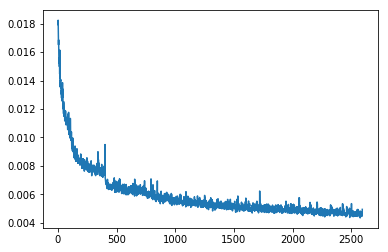

epoch: 2626; mse: 0.00365; latent: 0.003; avg mse: 0.00387; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.08it/s]
epoch: 2627; mse: 0.00387; latent: 0.003; avg mse: 0.00383; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.61it/s]
epoch: 2628; mse: 0.00399; latent: 0.003; avg mse: 0.00405; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.03it/s]
epoch: 2629; mse: 0.00403; latent: 0.003; avg mse: 0.00386; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.76it/s]
epoch: 2630; mse: 0.00387; latent: 0.003; avg mse: 0.00388; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.30it/s]
epoch: 2631; mse: 0.00363; latent: 0.003; avg mse: 0.00389; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.52it/s]
epoch: 2632; mse: 0.00417; latent: 0.003; avg mse: 0.00387; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.07it/s]
epoch: 2633; mse: 0.00383; latent: 0.003; avg mse: 0.00380; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.50it/s]
epoch: 2634; mse: 0.00393; latent: 0.003

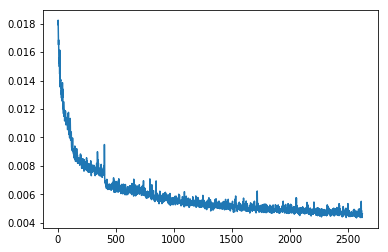

epoch: 2658; mse: 0.00377; latent: 0.003; avg mse: 0.00375; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.48it/s]
epoch: 2659; mse: 0.00407; latent: 0.003; avg mse: 0.00381; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.87it/s]
epoch: 2660; mse: 0.00389; latent: 0.003; avg mse: 0.00395; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.87it/s]
epoch: 2661; mse: 0.00386; latent: 0.003; avg mse: 0.00384; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 2662; mse: 0.00357; latent: 0.003; avg mse: 0.00382; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.40it/s]
epoch: 2663; mse: 0.00375; latent: 0.003; avg mse: 0.00377; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.48it/s]
epoch: 2664; mse: 0.00355; latent: 0.003; avg mse: 0.00377; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.30it/s]
epoch: 2665; mse: 0.00378; latent: 0.003; avg mse: 0.00370; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 2666; mse: 0.00364; latent: 0.003

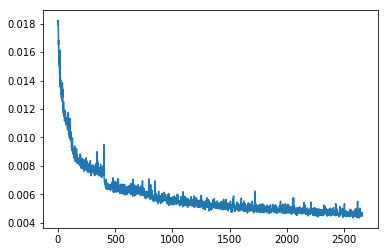

epoch: 2690; mse: 0.00370; latent: 0.003; avg mse: 0.00373; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 2691; mse: 0.00384; latent: 0.003; avg mse: 0.00380; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.85it/s]
epoch: 2692; mse: 0.00382; latent: 0.003; avg mse: 0.00372; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 2693; mse: 0.00390; latent: 0.003; avg mse: 0.00396; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.69it/s]
epoch: 2694; mse: 0.00359; latent: 0.003; avg mse: 0.00375; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.29it/s]
epoch: 2695; mse: 0.00365; latent: 0.003; avg mse: 0.00378; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.46it/s]
epoch: 2696; mse: 0.00386; latent: 0.003; avg mse: 0.00386; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.47it/s]
epoch: 2697; mse: 0.00379; latent: 0.003; avg mse: 0.00374; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.47it/s]
epoch: 2698; mse: 0.00388; latent: 0.003

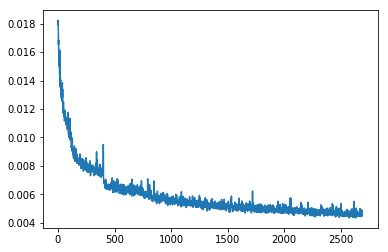

epoch: 2722; mse: 0.00370; latent: 0.003; avg mse: 0.00381; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.80it/s]
epoch: 2723; mse: 0.00388; latent: 0.003; avg mse: 0.00372; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.96it/s]
epoch: 2724; mse: 0.00383; latent: 0.003; avg mse: 0.00372; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.17it/s]
epoch: 2725; mse: 0.00373; latent: 0.003; avg mse: 0.00369; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.78it/s]
epoch: 2726; mse: 0.00378; latent: 0.003; avg mse: 0.00379; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.36it/s]
epoch: 2727; mse: 0.00377; latent: 0.003; avg mse: 0.00378; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.48it/s]
epoch: 2728; mse: 0.00368; latent: 0.003; avg mse: 0.00371; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.44it/s]
epoch: 2729; mse: 0.00362; latent: 0.003; avg mse: 0.00369; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.68it/s]
epoch: 2730; mse: 0.00369; latent: 0.003

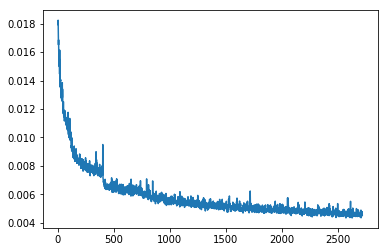

epoch: 2754; mse: 0.00385; latent: 0.003; avg mse: 0.00382; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.75it/s]
epoch: 2755; mse: 0.00395; latent: 0.003; avg mse: 0.00397; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.99it/s]
epoch: 2756; mse: 0.00382; latent: 0.003; avg mse: 0.00375; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.80it/s]
epoch: 2757; mse: 0.00370; latent: 0.003; avg mse: 0.00378; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.56it/s]
epoch: 2758; mse: 0.00379; latent: 0.003; avg mse: 0.00381; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.75it/s]
epoch: 2759; mse: 0.00381; latent: 0.004; avg mse: 0.00375; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.62it/s]
epoch: 2760; mse: 0.00378; latent: 0.003; avg mse: 0.00377; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.56it/s]
epoch: 2761; mse: 0.00366; latent: 0.003; avg mse: 0.00372; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.55it/s]
epoch: 2762; mse: 0.00369; latent: 0.003

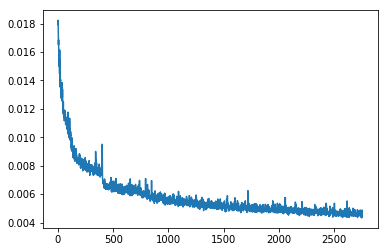

epoch: 2786; mse: 0.00385; latent: 0.003; avg mse: 0.00384; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.77it/s]
epoch: 2787; mse: 0.00363; latent: 0.003; avg mse: 0.00369; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 2788; mse: 0.00360; latent: 0.003; avg mse: 0.00366; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.76it/s]
epoch: 2789; mse: 0.00413; latent: 0.003; avg mse: 0.00385; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.80it/s]
epoch: 2790; mse: 0.00376; latent: 0.003; avg mse: 0.00376; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.79it/s]
epoch: 2791; mse: 0.00361; latent: 0.003; avg mse: 0.00375; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.59it/s]
epoch: 2792; mse: 0.00387; latent: 0.003; avg mse: 0.00375; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.95it/s]
epoch: 2793; mse: 0.00369; latent: 0.003; avg mse: 0.00379; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.88it/s]
epoch: 2794; mse: 0.00404; latent: 0.003

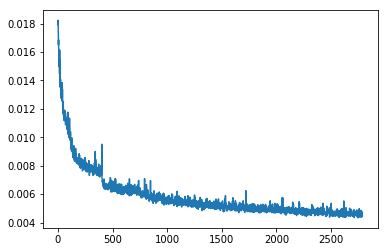

epoch: 2818; mse: 0.00386; latent: 0.003; avg mse: 0.00381; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.39it/s]
epoch: 2819; mse: 0.00380; latent: 0.003; avg mse: 0.00383; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 2820; mse: 0.00392; latent: 0.003; avg mse: 0.00380; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.66it/s]
epoch: 2821; mse: 0.00351; latent: 0.003; avg mse: 0.00364; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.43it/s]
epoch: 2822; mse: 0.00375; latent: 0.003; avg mse: 0.00375; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 2823; mse: 0.00378; latent: 0.003; avg mse: 0.00367; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.43it/s]
epoch: 2824; mse: 0.00379; latent: 0.003; avg mse: 0.00373; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.51it/s]
epoch: 2825; mse: 0.00398; latent: 0.003; avg mse: 0.00405; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.03it/s]
epoch: 2826; mse: 0.00374; latent: 0.003

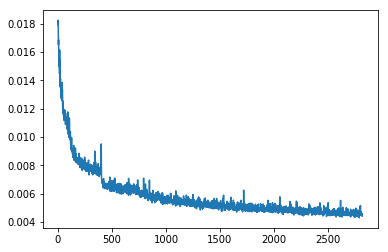

epoch: 2850; mse: 0.00416; latent: 0.003; avg mse: 0.00397; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.22it/s]
epoch: 2851; mse: 0.00405; latent: 0.003; avg mse: 0.00391; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.50it/s]
epoch: 2852; mse: 0.00382; latent: 0.003; avg mse: 0.00379; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.17it/s]
epoch: 2853; mse: 0.00381; latent: 0.003; avg mse: 0.00378; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.65it/s]
epoch: 2854; mse: 0.00379; latent: 0.003; avg mse: 0.00382; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.44it/s]
epoch: 2855; mse: 0.00390; latent: 0.003; avg mse: 0.00381; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.48it/s]
epoch: 2856; mse: 0.00385; latent: 0.003; avg mse: 0.00377; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.29it/s]
epoch: 2857; mse: 0.00374; latent: 0.003; avg mse: 0.00371; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.38it/s]
epoch: 2858; mse: 0.00376; latent: 0.003

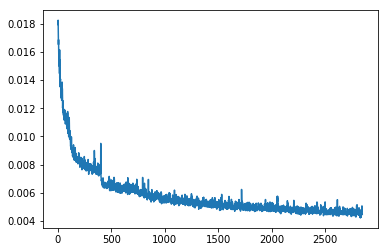

epoch: 2882; mse: 0.00380; latent: 0.003; avg mse: 0.00372; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 2883; mse: 0.00378; latent: 0.003; avg mse: 0.00369; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.25it/s]
epoch: 2884; mse: 0.00373; latent: 0.003; avg mse: 0.00372; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.62it/s]
epoch: 2885; mse: 0.00361; latent: 0.003; avg mse: 0.00371; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.29it/s]
epoch: 2886; mse: 0.00384; latent: 0.003; avg mse: 0.00376; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.60it/s]
epoch: 2887; mse: 0.00380; latent: 0.003; avg mse: 0.00371; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.41it/s]
epoch: 2888; mse: 0.00375; latent: 0.004; avg mse: 0.00363; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.54it/s]
epoch: 2889; mse: 0.00374; latent: 0.003; avg mse: 0.00374; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.42it/s]
epoch: 2890; mse: 0.00378; latent: 0.003

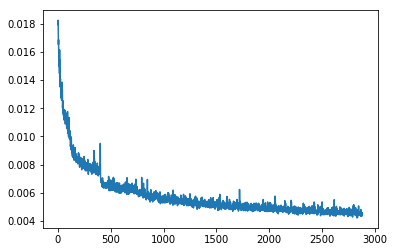

epoch: 2914; mse: 0.00366; latent: 0.003; avg mse: 0.00370; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.93it/s]
epoch: 2915; mse: 0.00372; latent: 0.003; avg mse: 0.00371; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.95it/s]
epoch: 2916; mse: 0.00377; latent: 0.003; avg mse: 0.00380; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.13it/s]
epoch: 2917; mse: 0.00363; latent: 0.003; avg mse: 0.00367; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.32it/s]
epoch: 2918; mse: 0.00353; latent: 0.003; avg mse: 0.00364; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.49it/s]
epoch: 2919; mse: 0.00386; latent: 0.003; avg mse: 0.00378; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.47it/s]
epoch: 2920; mse: 0.00370; latent: 0.003; avg mse: 0.00372; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.58it/s]
epoch: 2921; mse: 0.00368; latent: 0.003; avg mse: 0.00380; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.38it/s]
epoch: 2922; mse: 0.00354; latent: 0.003

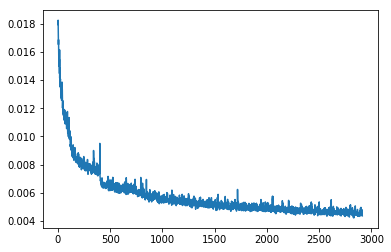

epoch: 2946; mse: 0.00364; latent: 0.003; avg mse: 0.00374; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.45it/s]
epoch: 2947; mse: 0.00382; latent: 0.003; avg mse: 0.00378; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 2948; mse: 0.00407; latent: 0.003; avg mse: 0.00381; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.31it/s]
epoch: 2949; mse: 0.00394; latent: 0.003; avg mse: 0.00387; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.70it/s]
epoch: 2950; mse: 0.00414; latent: 0.003; avg mse: 0.00387; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.03it/s]
epoch: 2951; mse: 0.00381; latent: 0.004; avg mse: 0.00377; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.67it/s]
epoch: 2952; mse: 0.00377; latent: 0.003; avg mse: 0.00368; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.07it/s]
epoch: 2953; mse: 0.00368; latent: 0.003; avg mse: 0.00373; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.79it/s]
epoch: 2954; mse: 0.00364; latent: 0.003

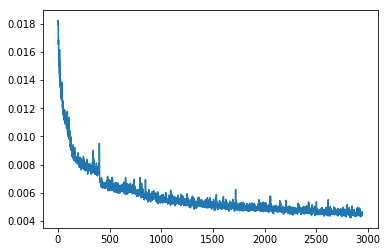

epoch: 2978; mse: 0.00353; latent: 0.003; avg mse: 0.00366; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.84it/s]
epoch: 2979; mse: 0.00367; latent: 0.003; avg mse: 0.00362; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.55it/s]
epoch: 2980; mse: 0.00376; latent: 0.003; avg mse: 0.00386; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.79it/s]
epoch: 2981; mse: 0.00339; latent: 0.003; avg mse: 0.00366; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 2982; mse: 0.00367; latent: 0.003; avg mse: 0.00367; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.31it/s]
epoch: 2983; mse: 0.00356; latent: 0.003; avg mse: 0.00375; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.73it/s]
epoch: 2984; mse: 0.00368; latent: 0.003; avg mse: 0.00365; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.15it/s]
epoch: 2985; mse: 0.00359; latent: 0.003; avg mse: 0.00367; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.63it/s]
epoch: 2986; mse: 0.00363; latent: 0.003

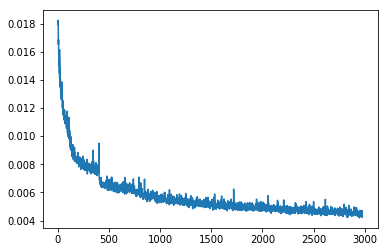

epoch: 3010; mse: 0.00410; latent: 0.003; avg mse: 0.00396; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.11it/s]
epoch: 3011; mse: 0.00370; latent: 0.003; avg mse: 0.00385; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.02it/s]
epoch: 3012; mse: 0.00384; latent: 0.003; avg mse: 0.00380; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.18it/s]
epoch: 3013; mse: 0.00365; latent: 0.003; avg mse: 0.00365; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.75it/s]
epoch: 3014; mse: 0.00373; latent: 0.003; avg mse: 0.00379; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.92it/s]
epoch: 3015; mse: 0.00351; latent: 0.003; avg mse: 0.00383; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.89it/s]
epoch: 3016; mse: 0.00371; latent: 0.003; avg mse: 0.00368; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.10it/s]
epoch: 3017; mse: 0.00374; latent: 0.003; avg mse: 0.00371; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.08it/s]
epoch: 3018; mse: 0.00371; latent: 0.003

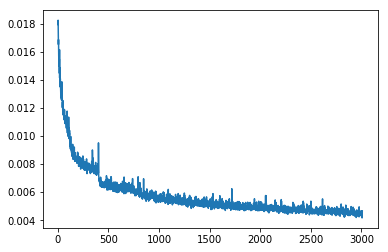

epoch: 3042; mse: 0.00370; latent: 0.003; avg mse: 0.00369; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.69it/s]
epoch: 3043; mse: 0.00365; latent: 0.003; avg mse: 0.00365; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.73it/s]
epoch: 3044; mse: 0.00369; latent: 0.003; avg mse: 0.00376; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 3045; mse: 0.00367; latent: 0.003; avg mse: 0.00371; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.61it/s]
epoch: 3046; mse: 0.00373; latent: 0.003; avg mse: 0.00376; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 3047; mse: 0.00362; latent: 0.003; avg mse: 0.00363; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 3048; mse: 0.00355; latent: 0.003; avg mse: 0.00365; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.71it/s]
epoch: 3049; mse: 0.00367; latent: 0.003; avg mse: 0.00359; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.67it/s]
epoch: 3050; mse: 0.00373; latent: 0.003

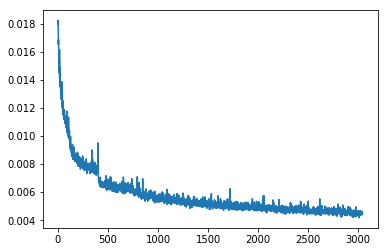

epoch: 3074; mse: 0.00345; latent: 0.003; avg mse: 0.00358; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.89it/s]
epoch: 3075; mse: 0.00366; latent: 0.003; avg mse: 0.00375; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.76it/s]
epoch: 3076; mse: 0.00371; latent: 0.003; avg mse: 0.00372; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.01it/s]
epoch: 3077; mse: 0.00368; latent: 0.003; avg mse: 0.00369; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.67it/s]
epoch: 3078; mse: 0.00370; latent: 0.003; avg mse: 0.00374; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.09it/s]
epoch: 3079; mse: 0.00364; latent: 0.003; avg mse: 0.00370; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.52it/s]
epoch: 3080; mse: 0.00399; latent: 0.003; avg mse: 0.00373; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.12it/s]
epoch: 3081; mse: 0.00356; latent: 0.003; avg mse: 0.00367; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.65it/s]
epoch: 3082; mse: 0.00361; latent: 0.003

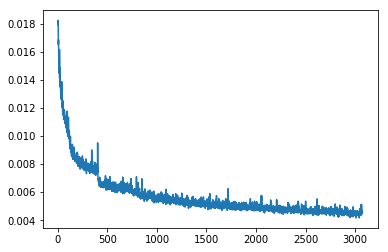

epoch: 3106; mse: 0.00360; latent: 0.003; avg mse: 0.00360; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.62it/s]
epoch: 3107; mse: 0.00348; latent: 0.003; avg mse: 0.00363; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.26it/s]
epoch: 3108; mse: 0.00371; latent: 0.003; avg mse: 0.00375; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.68it/s]
epoch: 3109; mse: 0.00353; latent: 0.003; avg mse: 0.00366; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.88it/s]
epoch: 3110; mse: 0.00381; latent: 0.003; avg mse: 0.00371; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.93it/s]
epoch: 3111; mse: 0.00368; latent: 0.003; avg mse: 0.00380; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.03it/s]
epoch: 3112; mse: 0.00368; latent: 0.003; avg mse: 0.00372; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.02it/s]
epoch: 3113; mse: 0.00384; latent: 0.003; avg mse: 0.00378; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.77it/s]
epoch: 3114; mse: 0.00370; latent: 0.003

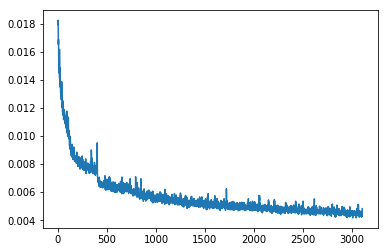

epoch: 3138; mse: 0.00381; latent: 0.003; avg mse: 0.00375; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.67it/s]
epoch: 3139; mse: 0.00390; latent: 0.003; avg mse: 0.00384; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.88it/s]
epoch: 3140; mse: 0.00365; latent: 0.003; avg mse: 0.00371; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.98it/s]
epoch: 3141; mse: 0.00363; latent: 0.003; avg mse: 0.00373; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.61it/s]
epoch: 3142; mse: 0.00371; latent: 0.003; avg mse: 0.00368; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.48it/s]
epoch: 3143; mse: 0.00376; latent: 0.003; avg mse: 0.00381; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.53it/s]
epoch: 3144; mse: 0.00357; latent: 0.003; avg mse: 0.00368; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.36it/s]
epoch: 3145; mse: 0.00359; latent: 0.003; avg mse: 0.00379; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.52it/s]
epoch: 3146; mse: 0.00388; latent: 0.003

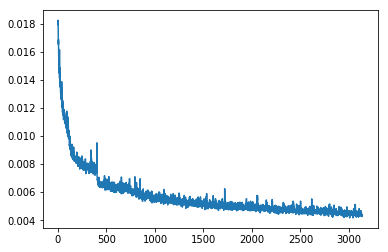

epoch: 3170; mse: 0.00352; latent: 0.003; avg mse: 0.00362; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 3171; mse: 0.00357; latent: 0.003; avg mse: 0.00364; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.51it/s]
epoch: 3172; mse: 0.00362; latent: 0.003; avg mse: 0.00363; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.69it/s]
epoch: 3173; mse: 0.00376; latent: 0.003; avg mse: 0.00366; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.48it/s]
epoch: 3174; mse: 0.00369; latent: 0.003; avg mse: 0.00367; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.45it/s]
epoch: 3175; mse: 0.00359; latent: 0.003; avg mse: 0.00361; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.47it/s]
epoch: 3176; mse: 0.00345; latent: 0.003; avg mse: 0.00361; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.50it/s]
epoch: 3177; mse: 0.00371; latent: 0.003; avg mse: 0.00363; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.95it/s]
epoch: 3178; mse: 0.00403; latent: 0.003

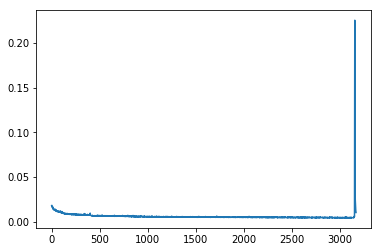

epoch: 3202; mse: 0.00809; latent: 0.008; avg mse: 0.00827; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.06it/s]
epoch: 3203; mse: 0.00820; latent: 0.007; avg mse: 0.00811; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.80it/s]
epoch: 3204; mse: 0.00752; latent: 0.006; avg mse: 0.00775; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.16it/s]
epoch: 3205; mse: 0.00779; latent: 0.006; avg mse: 0.00766; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.69it/s]
epoch: 3206; mse: 0.00723; latent: 0.006; avg mse: 0.00729; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.97it/s]
epoch: 3207; mse: 0.00730; latent: 0.006; avg mse: 0.00734; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.83it/s]
epoch: 3208; mse: 0.00699; latent: 0.006; avg mse: 0.00714; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.20it/s]
epoch: 3209; mse: 0.00716; latent: 0.006; avg mse: 0.00700; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.96it/s]
epoch: 3210; mse: 0.00698; latent: 0.006

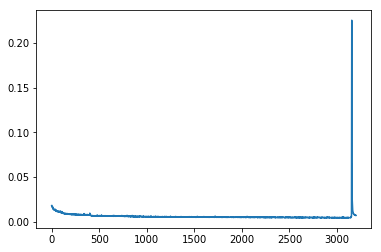

epoch: 3234; mse: 0.00568; latent: 0.004; avg mse: 0.00575; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.32it/s]
epoch: 3235; mse: 0.00559; latent: 0.004; avg mse: 0.00571; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 3236; mse: 0.00562; latent: 0.004; avg mse: 0.00572; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.55it/s]
epoch: 3237; mse: 0.00579; latent: 0.004; avg mse: 0.00567; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 3238; mse: 0.00536; latent: 0.004; avg mse: 0.00563; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.35it/s]
epoch: 3239; mse: 0.00536; latent: 0.004; avg mse: 0.00558; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.56it/s]
epoch: 3240; mse: 0.00557; latent: 0.004; avg mse: 0.00568; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.41it/s]
epoch: 3241; mse: 0.00563; latent: 0.004; avg mse: 0.00571; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.46it/s]
epoch: 3242; mse: 0.00578; latent: 0.004

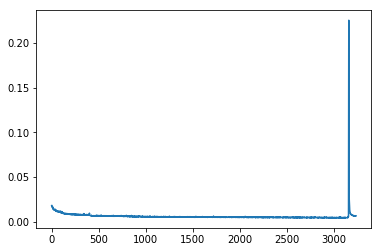

epoch: 3266; mse: 0.00532; latent: 0.004; avg mse: 0.00525; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.84it/s]
epoch: 3267; mse: 0.00512; latent: 0.004; avg mse: 0.00517; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.61it/s]
epoch: 3268; mse: 0.00553; latent: 0.004; avg mse: 0.00524; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.23it/s]
epoch: 3269; mse: 0.00510; latent: 0.004; avg mse: 0.00535; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.66it/s]
epoch: 3270; mse: 0.00533; latent: 0.004; avg mse: 0.00524; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.04it/s]
epoch: 3271; mse: 0.00516; latent: 0.004; avg mse: 0.00529; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.44it/s]
epoch: 3272; mse: 0.00531; latent: 0.004; avg mse: 0.00527; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.20it/s]
epoch: 3273; mse: 0.00524; latent: 0.004; avg mse: 0.00543; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.63it/s]
epoch: 3274; mse: 0.00533; latent: 0.004

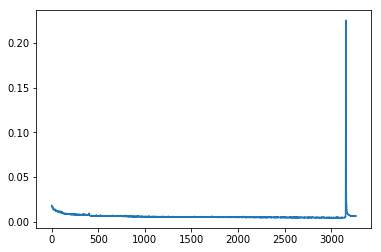

epoch: 3298; mse: 0.00530; latent: 0.004; avg mse: 0.00512; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.48it/s]
epoch: 3299; mse: 0.00490; latent: 0.004; avg mse: 0.00501; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.56it/s]
epoch: 3300; mse: 0.00494; latent: 0.004; avg mse: 0.00499; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.50it/s]
epoch: 3301; mse: 0.00494; latent: 0.004; avg mse: 0.00503; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.78it/s]
epoch: 3302; mse: 0.00495; latent: 0.004; avg mse: 0.00503; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.64it/s]
epoch: 3303; mse: 0.00498; latent: 0.004; avg mse: 0.00501; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.67it/s]
epoch: 3304; mse: 0.00501; latent: 0.004; avg mse: 0.00508; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.67it/s]
epoch: 3305; mse: 0.00518; latent: 0.004; avg mse: 0.00503; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.56it/s]
epoch: 3306; mse: 0.00505; latent: 0.004

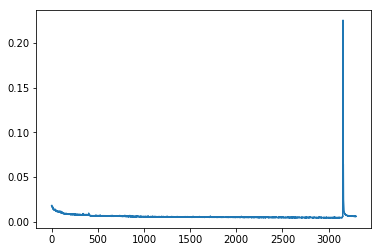

epoch: 3330; mse: 0.00508; latent: 0.004; avg mse: 0.00495; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.90it/s]
epoch: 3331; mse: 0.00516; latent: 0.004; avg mse: 0.00500; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.93it/s]
epoch: 3332; mse: 0.00527; latent: 0.004; avg mse: 0.00498; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.98it/s]
epoch: 3333; mse: 0.00513; latent: 0.004; avg mse: 0.00496; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.04it/s]
epoch: 3334; mse: 0.00477; latent: 0.004; avg mse: 0.00492; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.77it/s]
epoch: 3335; mse: 0.00505; latent: 0.004; avg mse: 0.00499; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.04it/s]
epoch: 3336; mse: 0.00497; latent: 0.004; avg mse: 0.00480; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.05it/s]
epoch: 3337; mse: 0.00492; latent: 0.004; avg mse: 0.00496; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.04it/s]
epoch: 3338; mse: 0.00508; latent: 0.004

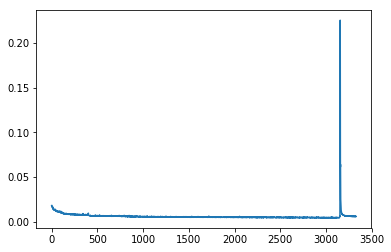

epoch: 3362; mse: 0.00500; latent: 0.004; avg mse: 0.00486; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.83it/s]
epoch: 3363; mse: 0.00480; latent: 0.004; avg mse: 0.00496; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.15it/s]
epoch: 3364; mse: 0.00514; latent: 0.004; avg mse: 0.00499; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.89it/s]
epoch: 3365; mse: 0.00466; latent: 0.004; avg mse: 0.00483; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.14it/s]
epoch: 3366; mse: 0.00490; latent: 0.004; avg mse: 0.00485; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.93it/s]
epoch: 3367; mse: 0.00480; latent: 0.004; avg mse: 0.00478; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.85it/s]
epoch: 3368; mse: 0.00502; latent: 0.004; avg mse: 0.00498; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.07it/s]
epoch: 3369; mse: 0.00518; latent: 0.004; avg mse: 0.00497; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.63it/s]
epoch: 3370; mse: 0.00479; latent: 0.004

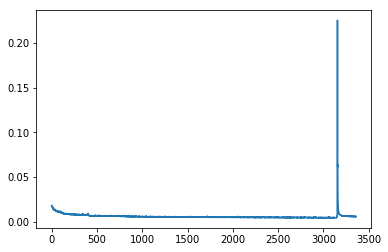

epoch: 3394; mse: 0.00454; latent: 0.004; avg mse: 0.00471; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.66it/s]
epoch: 3395; mse: 0.00468; latent: 0.004; avg mse: 0.00474; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.07it/s]
epoch: 3396; mse: 0.00459; latent: 0.004; avg mse: 0.00467; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.75it/s]
epoch: 3397; mse: 0.00479; latent: 0.004; avg mse: 0.00473; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.96it/s]
epoch: 3398; mse: 0.00497; latent: 0.004; avg mse: 0.00479; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.91it/s]
epoch: 3399; mse: 0.00464; latent: 0.004; avg mse: 0.00472; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.99it/s]
epoch: 3400; mse: 0.00468; latent: 0.004; avg mse: 0.00484; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.69it/s]
epoch: 3401; mse: 0.00465; latent: 0.004; avg mse: 0.00474; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.01it/s]
epoch: 3402; mse: 0.00484; latent: 0.004

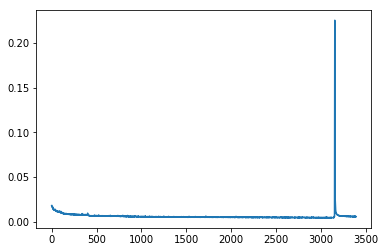

epoch: 3426; mse: 0.00501; latent: 0.004; avg mse: 0.00487; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.93it/s]
epoch: 3427; mse: 0.00470; latent: 0.004; avg mse: 0.00475; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.67it/s]
epoch: 3428; mse: 0.00500; latent: 0.004; avg mse: 0.00476; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.16it/s]
epoch: 3429; mse: 0.00458; latent: 0.004; avg mse: 0.00476; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 3430; mse: 0.00474; latent: 0.004; avg mse: 0.00489; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.09it/s]
epoch: 3431; mse: 0.00467; latent: 0.004; avg mse: 0.00475; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.71it/s]
epoch: 3432; mse: 0.00496; latent: 0.004; avg mse: 0.00496; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.32it/s]
epoch: 3433; mse: 0.00476; latent: 0.004; avg mse: 0.00479; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.45it/s]
epoch: 3434; mse: 0.00460; latent: 0.004

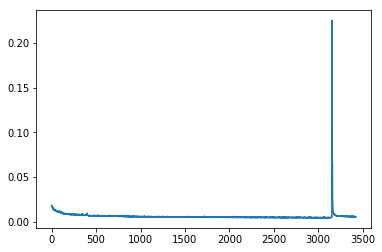

epoch: 3458; mse: 0.00438; latent: 0.004; avg mse: 0.00459; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.20it/s]
epoch: 3459; mse: 0.00493; latent: 0.003; avg mse: 0.00472; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 3460; mse: 0.00460; latent: 0.004; avg mse: 0.00461; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.97it/s]
epoch: 3461; mse: 0.00468; latent: 0.004; avg mse: 0.00464; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.88it/s]
epoch: 3462; mse: 0.00482; latent: 0.004; avg mse: 0.00467; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.09it/s]
epoch: 3463; mse: 0.00496; latent: 0.004; avg mse: 0.00473; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.72it/s]
epoch: 3464; mse: 0.00479; latent: 0.004; avg mse: 0.00469; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.78it/s]
epoch: 3465; mse: 0.00474; latent: 0.004; avg mse: 0.00454; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.87it/s]
epoch: 3466; mse: 0.00459; latent: 0.004

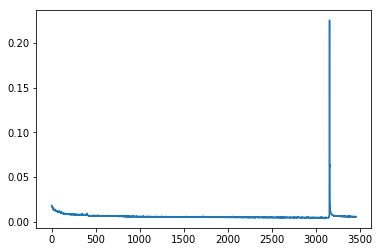

epoch: 3490; mse: 0.00482; latent: 0.004; avg mse: 0.00467; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.49it/s]
epoch: 3491; mse: 0.00472; latent: 0.004; avg mse: 0.00460; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.29it/s]
epoch: 3492; mse: 0.00472; latent: 0.004; avg mse: 0.00470; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.50it/s]
epoch: 3493; mse: 0.00479; latent: 0.004; avg mse: 0.00458; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.46it/s]
epoch: 3494; mse: 0.00476; latent: 0.004; avg mse: 0.00467; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.59it/s]
epoch: 3495; mse: 0.00460; latent: 0.004; avg mse: 0.00460; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.54it/s]
epoch: 3496; mse: 0.00437; latent: 0.004; avg mse: 0.00457; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.51it/s]
epoch: 3497; mse: 0.00480; latent: 0.004; avg mse: 0.00463; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.91it/s]
epoch: 3498; mse: 0.00463; latent: 0.004

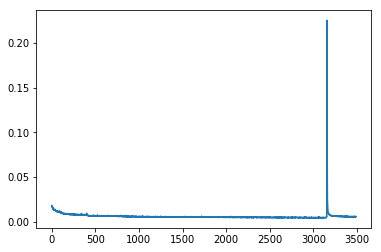

epoch: 3522; mse: 0.00485; latent: 0.004; avg mse: 0.00460; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.71it/s]
epoch: 3523; mse: 0.00438; latent: 0.004; avg mse: 0.00462; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.19it/s]
epoch: 3524; mse: 0.00469; latent: 0.003; avg mse: 0.00452; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.79it/s]
epoch: 3525; mse: 0.00485; latent: 0.003; avg mse: 0.00468; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.07it/s]
epoch: 3526; mse: 0.00455; latent: 0.004; avg mse: 0.00465; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.45it/s]
epoch: 3527; mse: 0.00482; latent: 0.004; avg mse: 0.00462; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.23it/s]
epoch: 3528; mse: 0.00453; latent: 0.004; avg mse: 0.00456; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.61it/s]
epoch: 3529; mse: 0.00454; latent: 0.004; avg mse: 0.00447; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.14it/s]
epoch: 3530; mse: 0.00452; latent: 0.003

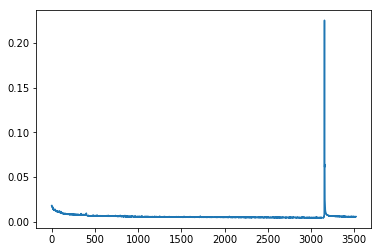

epoch: 3554; mse: 0.00455; latent: 0.004; avg mse: 0.00455; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.37it/s]
epoch: 3555; mse: 0.00470; latent: 0.004; avg mse: 0.00461; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.47it/s]
epoch: 3556; mse: 0.00446; latent: 0.004; avg mse: 0.00463; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.39it/s]
epoch: 3557; mse: 0.00444; latent: 0.003; avg mse: 0.00450; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.52it/s]
epoch: 3558; mse: 0.00474; latent: 0.003; avg mse: 0.00464; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.92it/s]
epoch: 3559; mse: 0.00465; latent: 0.004; avg mse: 0.00463; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.16it/s]
epoch: 3560; mse: 0.00450; latent: 0.004; avg mse: 0.00454; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.94it/s]
epoch: 3561; mse: 0.00448; latent: 0.004; avg mse: 0.00443; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.68it/s]
epoch: 3562; mse: 0.00458; latent: 0.004

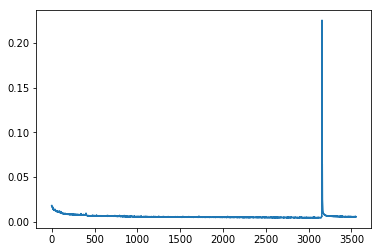

epoch: 3586; mse: 0.00432; latent: 0.004; avg mse: 0.00437; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.91it/s]
epoch: 3587; mse: 0.00470; latent: 0.003; avg mse: 0.00457; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.47it/s]
epoch: 3588; mse: 0.00453; latent: 0.003; avg mse: 0.00456; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.76it/s]
epoch: 3589; mse: 0.00444; latent: 0.003; avg mse: 0.00444; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.61it/s]
epoch: 3590; mse: 0.00457; latent: 0.003; avg mse: 0.00464; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.93it/s]
epoch: 3591; mse: 0.00444; latent: 0.004; avg mse: 0.00446; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.48it/s]
epoch: 3592; mse: 0.00463; latent: 0.004; avg mse: 0.00445; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.51it/s]
epoch: 3593; mse: 0.00446; latent: 0.003; avg mse: 0.00452; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.78it/s]
epoch: 3594; mse: 0.00450; latent: 0.004

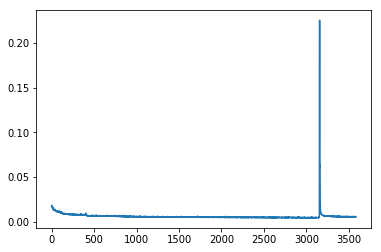

epoch: 3618; mse: 0.00442; latent: 0.003; avg mse: 0.00471; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.15it/s]
epoch: 3619; mse: 0.00454; latent: 0.004; avg mse: 0.00455; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.83it/s]
epoch: 3620; mse: 0.00442; latent: 0.003; avg mse: 0.00444; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.09it/s]
epoch: 3621; mse: 0.00450; latent: 0.003; avg mse: 0.00451; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.18it/s]
epoch: 3622; mse: 0.00441; latent: 0.004; avg mse: 0.00458; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.06it/s]
epoch: 3623; mse: 0.00474; latent: 0.004; avg mse: 0.00455; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.37it/s]
epoch: 3624; mse: 0.00469; latent: 0.004; avg mse: 0.00454; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.76it/s]
epoch: 3625; mse: 0.00436; latent: 0.003; avg mse: 0.00446; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.13it/s]
epoch: 3626; mse: 0.00434; latent: 0.003

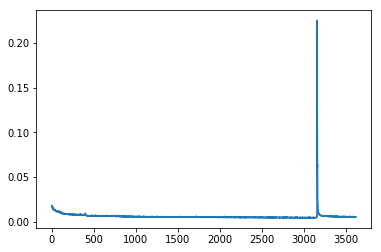

epoch: 3650; mse: 0.00458; latent: 0.004; avg mse: 0.00461; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.47it/s]
epoch: 3651; mse: 0.00439; latent: 0.003; avg mse: 0.00451; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.36it/s]
epoch: 3652; mse: 0.00445; latent: 0.003; avg mse: 0.00442; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.02it/s]
epoch: 3653; mse: 0.00461; latent: 0.003; avg mse: 0.00452; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.87it/s]
epoch: 3654; mse: 0.00437; latent: 0.004; avg mse: 0.00434; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.12it/s]
epoch: 3655; mse: 0.00450; latent: 0.003; avg mse: 0.00439; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.74it/s]
epoch: 3656; mse: 0.00462; latent: 0.003; avg mse: 0.00459; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.98it/s]
epoch: 3657; mse: 0.00459; latent: 0.004; avg mse: 0.00465; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.68it/s]
epoch: 3658; mse: 0.00468; latent: 0.004

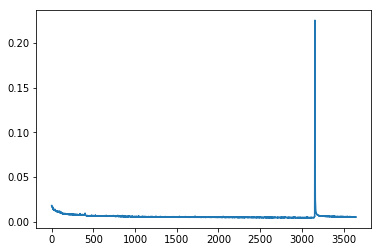

epoch: 3682; mse: 0.00452; latent: 0.003; avg mse: 0.00436; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.80it/s]
epoch: 3683; mse: 0.00426; latent: 0.003; avg mse: 0.00438; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.51it/s]
epoch: 3684; mse: 0.00450; latent: 0.004; avg mse: 0.00441; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.02it/s]
epoch: 3685; mse: 0.00455; latent: 0.004; avg mse: 0.00445; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.98it/s]
epoch: 3686; mse: 0.00449; latent: 0.004; avg mse: 0.00448; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.57it/s]
epoch: 3687; mse: 0.00463; latent: 0.003; avg mse: 0.00453; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.22it/s]
epoch: 3688; mse: 0.00427; latent: 0.003; avg mse: 0.00444; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.78it/s]
epoch: 3689; mse: 0.00435; latent: 0.004; avg mse: 0.00444; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.08it/s]
epoch: 3690; mse: 0.00425; latent: 0.003

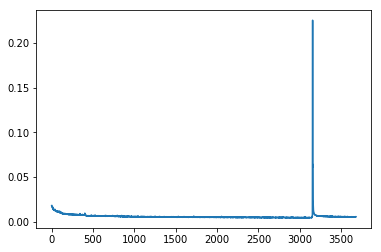

epoch: 3714; mse: 0.00449; latent: 0.003; avg mse: 0.00442; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.95it/s]
epoch: 3715; mse: 0.00440; latent: 0.003; avg mse: 0.00436; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.95it/s]
epoch: 3716; mse: 0.00425; latent: 0.004; avg mse: 0.00435; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.63it/s]
epoch: 3717; mse: 0.00425; latent: 0.004; avg mse: 0.00437; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.28it/s]
epoch: 3718; mse: 0.00446; latent: 0.004; avg mse: 0.00442; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.67it/s]
epoch: 3719; mse: 0.00431; latent: 0.003; avg mse: 0.00439; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.03it/s]
epoch: 3720; mse: 0.00430; latent: 0.003; avg mse: 0.00432; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.51it/s]
epoch: 3721; mse: 0.00465; latent: 0.003; avg mse: 0.00445; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.47it/s]
epoch: 3722; mse: 0.00428; latent: 0.003

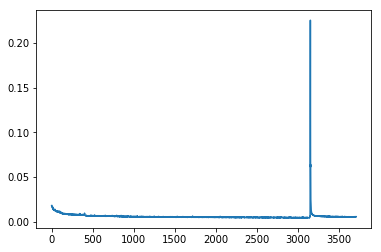

epoch: 3746; mse: 0.00432; latent: 0.003; avg mse: 0.00440; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.10it/s]
epoch: 3747; mse: 0.00427; latent: 0.003; avg mse: 0.00432; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.63it/s]
epoch: 3748; mse: 0.00436; latent: 0.003; avg mse: 0.00449; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.96it/s]
epoch: 3749; mse: 0.00438; latent: 0.004; avg mse: 0.00438; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.57it/s]
epoch: 3750; mse: 0.00418; latent: 0.003; avg mse: 0.00436; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.10it/s]
epoch: 3751; mse: 0.00452; latent: 0.003; avg mse: 0.00439; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.96it/s]
epoch: 3752; mse: 0.00460; latent: 0.003; avg mse: 0.00444; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.17it/s]
epoch: 3753; mse: 0.00438; latent: 0.003; avg mse: 0.00431; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.56it/s]
epoch: 3754; mse: 0.00444; latent: 0.003

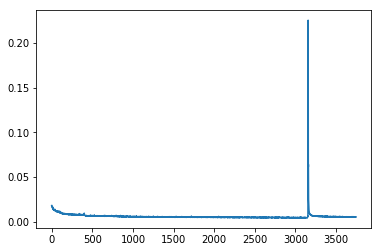

epoch: 3778; mse: 0.00473; latent: 0.004; avg mse: 0.00439; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.48it/s]
epoch: 3779; mse: 0.00437; latent: 0.004; avg mse: 0.00431; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.36it/s]
epoch: 3780; mse: 0.00428; latent: 0.003; avg mse: 0.00447; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.57it/s]
epoch: 3781; mse: 0.00454; latent: 0.003; avg mse: 0.00440; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.50it/s]
epoch: 3782; mse: 0.00432; latent: 0.003; avg mse: 0.00443; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.51it/s]
epoch: 3783; mse: 0.00439; latent: 0.004; avg mse: 0.00451; lr: 0.00060: 100%|███████████| 3/3 [00:00<00:00,  3.33it/s]
epoch: 3784; mse: 0.00457; latent: 0.003; avg mse: 0.00448; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.68it/s]
epoch: 3785; mse: 0.00437; latent: 0.003; avg mse: 0.00448; lr: 0.00060: 100%|███████████| 3/3 [00:01<00:00,  2.94it/s]
epoch: 3786; mse: 0.00424; latent: 0.004

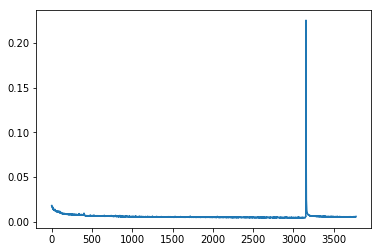

epoch: 3810; mse: 0.00449; latent: 0.003; avg mse: 0.00447; lr: 0.00060:  67%|███████▎   | 2/3 [00:00<00:00,  2.65it/s]

KeyboardInterrupt: 

In [10]:
losses = []
for i in range(n_epochs):
    loss = train_vqvae_model(i, train_loader, model, optimizer, device)
    if i > 30:
        losses.append(loss)
        if i % 32 == 0:
            torch.save(model.module.state_dict(), f'checkpoint/vqvae_{str(i + 1).zfill(3)}.pt')
            plt.plot(losses)
            plt.show()